# Named Entity Recognition using CRF model
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 
Information about lables: 
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

        1. Total Words Count = 1354149 
        2. Target Data Column: Tag

#### Importing Libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

In [2]:
#Reading the csv file
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

In [3]:
#Display first 10 rows
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 19756,the,NN,O
freq,1,52573,145807,887908


#### Observations : 
* There are total 47959 sentences in the dataset.
* Number unique words in the dataset are 35178.
* Total 17 lables (Tags).

In [5]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

There are lots of missing values in 'Sentence #' attribute. So we will use pandas fillna technique and use 'ffill' method which propagates last valid observation forward to next.

In [7]:
df = df.fillna(method = 'ffill')

In [8]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [9]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [10]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Getting all the sentences in the dataset.

In [11]:
sentences = getter.sentences

#### Feature Preparation
These are the default features used by the NER in nltk. We can also modify it for our customization.

In [12]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index][0],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index][0].upper() == sentence[index][0],
        'is_all_lower': sentence[index][0].lower() == sentence[index][0],
        'prefix-1': sentence[index][0][0],
        'prefix-2': sentence[index][0][:2],
        'prefix-3': sentence[index][0][:3],
        'suffix-1': sentence[index][0][-1],
        'suffix-2': sentence[index][0][-2:],
        'suffix-3': sentence[index][0][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1][0],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1][0],
        'has_hyphen': '-' in sentence[index][0],
        'is_numeric': sentence[index][0].isdigit(),
        'capitals_inside': sentence[index][0][1:].lower() != sentence[index][0][1:],
        'pos_tag': sentence[index][1]
    }

In [13]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    
    for tagged in tagged_sentences:
        X.append([features(tagged, index) for index in range(len(tagged))])
        y.append([tag for _,_, tag in tagged])
        
    return X, y

In [14]:
xt,yt = transform_to_dataset(sentences)

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(xt,yt,test_size=0.1, random_state=42)

In [16]:
model = CRF()
model.fit(xtrain,ytrain)

CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [17]:
from sklearn_crfsuite import metrics
 
y_pred = model.predict(xtest)
print(metrics.flat_accuracy_score(ytest, y_pred))

0.9720763380685895


In [18]:
import pickle
f = open('CRF.pickle', 'wb')
pickle.dump(model, f)
f.close()

In [80]:
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import WordPunctTokenizer
from sklearn import preprocessing
from tensorflow.keras import layers
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import random
import re
import tensorflow as tf

In [132]:
sentencesOnly = [" ".join([s[0] for s in sent]) for sent in sentences]
sentencesOnly = np.array(sentencesOnly)
sentencesOnly[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [133]:
len_sent = []
tok = WordPunctTokenizer()
for sent in sentencesOnly:
    len_sent.append(len(tok.tokenize(sent)))
print("Panjang maximum twitter:",np.max(len_sent))


Panjang maximum twitter: 128


In [134]:
print(len(sentences))
labels = []
for t in sentences:
    for tt in t:
        labels.append(tt[2])
print(len(labels))
labels = np.array(labels)
print(labels[0])

47959
1048575
O


In [135]:
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
print(list(le.classes_))
num_labels = [le.transform(pere) for pere in yt]
num_labels = np.array(num_labels)
num_labels = tf.keras.preprocessing.sequence.pad_sequences(num_labels, maxlen=128, padding='post', value=17)
padY = tf.keras.preprocessing.sequence.pad_sequences(yt, maxlen=128, padding='post', value='<PAD>', dtype=object)

['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']


In [136]:
print(num_labels[0])
print(padY[0])

[16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]
['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
 '<PAD>' '<PAD>' '<PAD>' '<PA

In [137]:
x_train, x_test, y_train, y_test = train_test_split(sentencesOnly, num_labels, test_size=0.1, random_state=42)

In [157]:
y_train = tf.keras.utils.to_categorical(y_train, 18)
y_test = tf.keras.utils.to_categorical(y_test, 18)

In [158]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

43163
4796
43163
4796


In [159]:
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(np.array(x_train))

In [160]:
vocab_size = len(t.word_index) + 1

In [161]:
max_length = 128

In [162]:
encodedXTrain = t.texts_to_sequences(x_train)
encodedXTest = t.texts_to_sequences(x_test)
padXTrain = tf.keras.preprocessing.sequence.pad_sequences(encodedXTrain, maxlen=max_length, padding='post')
padXTest = tf.keras.preprocessing.sequence.pad_sequences(encodedXTest, maxlen=max_length, padding='post')
print('Train:')
print(padXTrain)
print('Test:')
print(padXTest)

Train:
[[ 2760    33  2995 ...     0     0     0]
 [    1   534     2 ...     0     0     0]
 [    1   275    99 ...     0     0     0]
 ...
 [ 2542    66    37 ...     0     0     0]
 [ 5240  2968     1 ...     0     0     0]
 [  219    16 26894 ...     0     0     0]]
Test:
[[    1   144   498 ...     0     0     0]
 [    1   901    10 ...     0     0     0]
 [    1  2513    17 ...     0     0     0]
 ...
 [  748 19354 10076 ...     0     0     0]
 [   44    23    16 ...     0     0     0]
 [   30  5932  3652 ...     0     0     0]]


In [163]:
print(padXTrain.shape, y_train.shape)
print(padXTest.shape, y_test.shape)

(43163, 128) (43163, 128, 18)
(4796, 128) (4796, 128, 18)


In [164]:
w2vEmbedding = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True,limit=1000000)

In [165]:
def getEmbedVector(embedModel, word):
    embedVec = 2 * np.random.rand(embedModel.vector_size,) - 1
    if word in embedModel:
        embedVec = embedModel[word]
    elif word.lower() in embedModel:
        embedVec = embedModel[word.lower()]
    return embedVec

In [166]:
print(getEmbedVector(w2vEmbedding, 'asddgadf'))

[-0.37737952  0.21632385  0.23341181 -0.86728221 -0.40526607 -0.03622457
 -0.818419   -0.80017251  0.18759617 -0.98597832  0.32029645  0.4681212
  0.92933068 -0.03974984  0.1683383   0.86183849 -0.847588   -0.16565507
  0.78031181 -0.26053496 -0.99434648  0.59543855  0.42891514 -0.5452729
 -0.98068744 -0.52615386 -0.18815803  0.36015922 -0.09365806 -0.36849742
 -0.82932563  0.52312696 -0.08754242 -0.34773224 -0.69216273  0.17612305
 -0.86713951  0.17941086  0.84373924  0.39039959  0.00708625  0.54753205
 -0.45333069 -0.9773539   0.16529356  0.4013135   0.42354888 -0.36054171
 -0.35985509 -0.08056923  0.31952357 -0.05126512 -0.47473114 -0.99162395
  0.67629685 -0.99916995  0.71530183 -0.43214219 -0.03372135  0.48147649
  0.60563341  0.28209076 -0.18113671 -0.98582772  0.4055882   0.3211268
  0.51662992  0.34387819  0.20284729 -0.86032275  0.0578532   0.10621747
 -0.97424    -0.63083255 -0.50322207  0.78276883  0.37929889  0.9071851
 -0.44436453  0.71026489  0.58030866  0.60965951 -0.483

In [167]:
def get_weight_matrix(embedModel, vocab):
    vSize = len(vocab) + 1
    weight_matrix = np.zeros((vSize, embedModel.vector_size))
    for word, i in vocab.items():
        weight_matrix[i] = getEmbedVector(embedModel, word)
    return weight_matrix

In [168]:
embedding_vectors = get_weight_matrix(w2vEmbedding, t.word_index)
embedding_layer = layers.Embedding(vocab_size, w2vEmbedding.vector_size, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [172]:
RNNModel = tf.keras.models.Sequential()
RNNModel.add(embedding_layer)
RNNModel.add(layers.SimpleRNN(128,return_sequences=True))
RNNModel.add(layers.Dense(18, activation='softmax'))
RNNModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          8068500   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128, 128)          54912     
_________________________________________________________________
dense (Dense)                (None, 128, 18)           2322      
Total params: 8,125,734
Trainable params: 57,234
Non-trainable params: 8,068,500
_________________________________________________________________


In [173]:
RNNModel.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.RMSprop(),
                metrics = ['accuracy'])

In [175]:
epochs = 50
batch_size = 64
history = RNNModel.fit(padXTrain, y_train, epochs = epochs, batch_size = batch_size,
                      validation_split=0.1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/50


11776/38846 [========>.....................] - ETA: 59s - loss: 0.0820 - accuracy: 0.975 - ETA: 56s - loss: 0.0804 - accuracy: 0.976 - ETA: 55s - loss: 0.0851 - accuracy: 0.974 - ETA: 55s - loss: 0.0852 - accuracy: 0.974 - ETA: 54s - loss: 0.0843 - accuracy: 0.973 - ETA: 53s - loss: 0.0835 - accuracy: 0.974 - ETA: 53s - loss: 0.0846 - accuracy: 0.974 - ETA: 51s - loss: 0.0860 - accuracy: 0.973 - ETA: 50s - loss: 0.0861 - accuracy: 0.973 - ETA: 49s - loss: 0.0860 - accuracy: 0.973 - ETA: 49s - loss: 0.0850 - accuracy: 0.973 - ETA: 48s - loss: 0.0840 - accuracy: 0.974 - ETA: 48s - loss: 0.0853 - accuracy: 0.974 - ETA: 48s - loss: 0.0866 - accuracy: 0.973 - ETA: 48s - loss: 0.0868 - accuracy: 0.973 - ETA: 48s - loss: 0.0859 - accuracy: 0.973 - ETA: 48s - loss: 0.0860 - accuracy: 0.973 - ETA: 48s - loss: 0.0854 - accuracy: 0.974 - ETA: 47s - loss: 0.0846 - accuracy: 0.974 - ETA: 47s - loss: 0.0851 - accuracy: 0.974 - ETA: 47s - loss: 0.0853 - accuracy: 0.974 - ETA: 46s - loss: 0.0860 - acc

23680/38846 [=================>............] - ETA: 32s - loss: 0.0870 - accuracy: 0.973 - ETA: 32s - loss: 0.0869 - accuracy: 0.973 - ETA: 32s - loss: 0.0869 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0869 - accuracy: 0.974 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.973 - ETA: 31s - loss: 0.0870 - accuracy: 0.974 - ETA: 31s - loss: 0.0869 - accuracy: 0.974 - ETA: 31s - loss: 0.0869 - accuracy: 0.974 - ETA: 31s - loss: 0.0869 - accuracy: 0.974 - ETA: 30s - loss: 0.0869 - accuracy: 0.974 - ETA: 30s - loss: 0.0868 - accuracy: 0.974 - ETA: 30s - loss: 0.0868 - accuracy: 0.974 - ETA: 30s - loss: 0.0869 - accuracy: 0.974 - ETA: 30s - loss: 0.0869 - acc

35776/38846 [==========================>...] - ETA: 18s - loss: 0.0872 - accuracy: 0.974 - ETA: 17s - loss: 0.0872 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0871 - accuracy: 0.974 - ETA: 17s - loss: 0.0870 - accuracy: 0.974 - ETA: 16s - loss: 0.0870 - accuracy: 0.974 - ETA: 16s - loss: 0.0870 - accuracy: 0.974 - ETA: 16s - loss: 0.0871 - accuracy: 0.974 - ETA: 16s - loss: 0.0870 - accuracy: 0.974 - ETA: 16s - loss: 0.0870 - accuracy: 0.974 - ETA: 16s - loss: 0.0871 - accuracy: 0.974 - ETA: 16s - loss: 0.0871 - accuracy: 0.974 - ETA: 16s - loss: 0.0870 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0871 - accuracy: 0.97 - ETA: 3s - loss: 0.0871 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 3s - loss: 0.0871 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 1s - loss: 0.0871 - accuracy: 0.97 - ETA: 1s - loss: 0.0871 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0919 - accuracy: 0.974 - ETA: 45s - loss: 0.0890 - accuracy: 0.974 - ETA: 46s - loss: 0.0859 - accuracy: 0.974 - ETA: 45s - loss: 0.0819 - accuracy: 0.975 - ETA: 45s - loss: 0.0797 - accuracy: 0.976 - ETA: 45s - loss: 0.0827 - accuracy: 0.975 - ETA: 45s - loss: 0.0841 - accuracy: 0.975 - ETA: 45s - loss: 0.0859 - accuracy: 0.974 - ETA: 45s - loss: 0.0858 - accuracy: 0.974 - ETA: 45s - loss: 0.0857 - accuracy: 0.974 - ETA: 45s - loss: 0.0857 - accuracy: 0.974 - ETA: 45s - loss: 0.0852 - accuracy: 0.974 - ETA: 45s - loss: 0.0852 - accuracy: 0.974 - ETA: 45s - loss: 0.0842 - accuracy: 0.974 - ETA: 46s - loss: 0.0836 - accuracy: 0.974 - ETA: 46s - loss: 0.0830 - accuracy: 0.974 - ETA: 46s - loss: 0.0829 - accuracy: 0.975 - ETA: 46s - loss: 0.0849 - accuracy: 0.974 - ETA: 46s - loss: 0.0840 - accuracy: 0.974 - ETA: 46s - loss: 0.0841 - accuracy: 0.974 - ETA: 46s - loss: 0.0838 - accuracy: 0.974 - ETA: 46s - loss: 0.0839 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 32s - loss: 0.0845 - accuracy: 0.974 - ETA: 31s - loss: 0.0845 - accuracy: 0.974 - ETA: 31s - loss: 0.0845 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0845 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 31s - loss: 0.0843 - accuracy: 0.974 - ETA: 31s - loss: 0.0844 - accuracy: 0.974 - ETA: 30s - loss: 0.0844 - accuracy: 0.974 - ETA: 30s - loss: 0.0844 - accuracy: 0.974 - ETA: 30s - loss: 0.0843 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0850 - accuracy: 0.974 - ETA: 17s - loss: 0.0850 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 17s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0851 - accuracy: 0.974 - ETA: 16s - loss: 0.0852 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0844 - accuracy: 0.97 - ETA: 3s - loss: 0.0844 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accu

11904/38846 [========>.....................] - ETA: 44s - loss: 0.0846 - accuracy: 0.974 - ETA: 44s - loss: 0.0839 - accuracy: 0.974 - ETA: 44s - loss: 0.0833 - accuracy: 0.975 - ETA: 44s - loss: 0.0823 - accuracy: 0.975 - ETA: 46s - loss: 0.0827 - accuracy: 0.975 - ETA: 45s - loss: 0.0828 - accuracy: 0.975 - ETA: 44s - loss: 0.0818 - accuracy: 0.975 - ETA: 45s - loss: 0.0829 - accuracy: 0.975 - ETA: 44s - loss: 0.0838 - accuracy: 0.974 - ETA: 45s - loss: 0.0832 - accuracy: 0.975 - ETA: 45s - loss: 0.0836 - accuracy: 0.974 - ETA: 45s - loss: 0.0831 - accuracy: 0.975 - ETA: 45s - loss: 0.0829 - accuracy: 0.975 - ETA: 44s - loss: 0.0837 - accuracy: 0.974 - ETA: 44s - loss: 0.0848 - accuracy: 0.974 - ETA: 44s - loss: 0.0843 - accuracy: 0.974 - ETA: 44s - loss: 0.0847 - accuracy: 0.974 - ETA: 45s - loss: 0.0852 - accuracy: 0.974 - ETA: 45s - loss: 0.0847 - accuracy: 0.974 - ETA: 44s - loss: 0.0842 - accuracy: 0.974 - ETA: 44s - loss: 0.0837 - accuracy: 0.974 - ETA: 44s - loss: 0.0835 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0813 - accuracy: 0.975 - ETA: 32s - loss: 0.0813 - accuracy: 0.975 - ETA: 32s - loss: 0.0813 - accuracy: 0.975 - ETA: 32s - loss: 0.0813 - accuracy: 0.975 - ETA: 32s - loss: 0.0813 - accuracy: 0.975 - ETA: 32s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0815 - accuracy: 0.975 - ETA: 31s - loss: 0.0815 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 31s - loss: 0.0814 - accuracy: 0.975 - ETA: 30s - loss: 0.0814 - accuracy: 0.975 - ETA: 30s - loss: 0.0815 - accuracy: 0.975 - ETA: 30s - loss: 0.0814 - accuracy: 0.975 - ETA: 30s - loss: 0.0814 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0814 - accuracy: 0.975 - ETA: 18s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0813 - accuracy: 0.975 - ETA: 17s - loss: 0.0813 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0814 - accuracy: 0.975 - ETA: 17s - loss: 0.0815 - accuracy: 0.975 - ETA: 17s - loss: 0.0815 - accuracy: 0.975 - ETA: 17s - loss: 0.0815 - accuracy: 0.975 - ETA: 16s - loss: 0.0815 - accuracy: 0.975 - ETA: 16s - loss: 0.0814 - accuracy: 0.975 - ETA: 16s - loss: 0.0814 - accuracy: 0.975 - ETA: 16s - loss: 0.0814 - accuracy: 0.975 - ETA: 16s - loss: 0.0815 - accuracy: 0.975 - ETA: 16s - loss: 0.0814 - accuracy: 0.975 - ETA: 16s - loss: 0.0814 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0819 - accuracy: 0.97 - ETA: 3s - loss: 0.0819 - accuracy: 0.97 - ETA: 3s - loss: 0.0820 - accuracy: 0.97 - ETA: 3s - loss: 0.0819 - accuracy: 0.97 - ETA: 3s - loss: 0.0820 - accuracy: 0.97 - ETA: 3s - loss: 0.0819 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accu

11904/38846 [========>.....................] - ETA: 46s - loss: 0.0754 - accuracy: 0.977 - ETA: 50s - loss: 0.0880 - accuracy: 0.974 - ETA: 48s - loss: 0.0846 - accuracy: 0.974 - ETA: 48s - loss: 0.0798 - accuracy: 0.975 - ETA: 47s - loss: 0.0808 - accuracy: 0.975 - ETA: 47s - loss: 0.0805 - accuracy: 0.975 - ETA: 47s - loss: 0.0768 - accuracy: 0.976 - ETA: 47s - loss: 0.0762 - accuracy: 0.977 - ETA: 46s - loss: 0.0759 - accuracy: 0.976 - ETA: 46s - loss: 0.0769 - accuracy: 0.976 - ETA: 46s - loss: 0.0764 - accuracy: 0.976 - ETA: 46s - loss: 0.0748 - accuracy: 0.977 - ETA: 47s - loss: 0.0753 - accuracy: 0.977 - ETA: 47s - loss: 0.0753 - accuracy: 0.977 - ETA: 47s - loss: 0.0748 - accuracy: 0.976 - ETA: 47s - loss: 0.0750 - accuracy: 0.976 - ETA: 47s - loss: 0.0746 - accuracy: 0.977 - ETA: 46s - loss: 0.0748 - accuracy: 0.977 - ETA: 46s - loss: 0.0757 - accuracy: 0.976 - ETA: 46s - loss: 0.0756 - accuracy: 0.976 - ETA: 47s - loss: 0.0759 - accuracy: 0.976 - ETA: 47s - loss: 0.0761 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0801 - accuracy: 0.975 - ETA: 32s - loss: 0.0801 - accuracy: 0.975 - ETA: 32s - loss: 0.0801 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0801 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0801 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0800 - accuracy: 0.975 - ETA: 32s - loss: 0.0799 - accuracy: 0.975 - ETA: 31s - loss: 0.0798 - accuracy: 0.975 - ETA: 31s - loss: 0.0798 - accuracy: 0.975 - ETA: 31s - loss: 0.0799 - accuracy: 0.975 - ETA: 31s - loss: 0.0798 - accuracy: 0.975 - ETA: 31s - loss: 0.0799 - accuracy: 0.975 - ETA: 31s - loss: 0.0800 - accuracy: 0.975 - ETA: 31s - loss: 0.0801 - accuracy: 0.975 - ETA: 31s - loss: 0.0801 - accuracy: 0.975 - ETA: 31s - loss: 0.0802 - accuracy: 0.975 - ETA: 31s - loss: 0.0802 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0805 - accuracy: 0.975 - ETA: 18s - loss: 0.0805 - accuracy: 0.975 - ETA: 18s - loss: 0.0805 - accuracy: 0.975 - ETA: 18s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0803 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0804 - accuracy: 0.975 - ETA: 17s - loss: 0.0803 - accuracy: 0.975 - ETA: 16s - loss: 0.0803 - accuracy: 0.975 - ETA: 16s - loss: 0.0803 - accuracy: 0.975 - ETA: 16s - loss: 0.0803 - accuracy: 0.975 - ETA: 16s - loss: 0.0803 - accuracy: 0.975 - ETA: 16s - loss: 0.0803 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 1s - loss: 0.0800 - accuracy: 0.97 - ETA: 1s - loss: 0.0800 - accuracy: 0.97 - ETA: 1s - loss: 0.0800 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0817 - accuracy: 0.976 - ETA: 45s - loss: 0.0725 - accuracy: 0.979 - ETA: 44s - loss: 0.0735 - accuracy: 0.978 - ETA: 44s - loss: 0.0750 - accuracy: 0.977 - ETA: 43s - loss: 0.0728 - accuracy: 0.977 - ETA: 43s - loss: 0.0743 - accuracy: 0.976 - ETA: 43s - loss: 0.0740 - accuracy: 0.976 - ETA: 43s - loss: 0.0740 - accuracy: 0.976 - ETA: 43s - loss: 0.0730 - accuracy: 0.977 - ETA: 43s - loss: 0.0726 - accuracy: 0.977 - ETA: 43s - loss: 0.0713 - accuracy: 0.977 - ETA: 43s - loss: 0.0719 - accuracy: 0.977 - ETA: 43s - loss: 0.0733 - accuracy: 0.977 - ETA: 44s - loss: 0.0745 - accuracy: 0.977 - ETA: 44s - loss: 0.0747 - accuracy: 0.977 - ETA: 44s - loss: 0.0759 - accuracy: 0.976 - ETA: 44s - loss: 0.0764 - accuracy: 0.976 - ETA: 44s - loss: 0.0766 - accuracy: 0.976 - ETA: 44s - loss: 0.0764 - accuracy: 0.976 - ETA: 45s - loss: 0.0761 - accuracy: 0.976 - ETA: 45s - loss: 0.0768 - accuracy: 0.976 - ETA: 45s - loss: 0.0778 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0783 - accuracy: 0.976 - ETA: 32s - loss: 0.0782 - accuracy: 0.976 - ETA: 32s - loss: 0.0782 - accuracy: 0.976 - ETA: 32s - loss: 0.0782 - accuracy: 0.976 - ETA: 32s - loss: 0.0782 - accuracy: 0.976 - ETA: 32s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0782 - accuracy: 0.976 - ETA: 31s - loss: 0.0782 - accuracy: 0.976 - ETA: 31s - loss: 0.0782 - accuracy: 0.976 - ETA: 31s - loss: 0.0782 - accuracy: 0.976 - ETA: 31s - loss: 0.0782 - accuracy: 0.976 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0784 - accuracy: 0.975 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0783 - accuracy: 0.975 - ETA: 31s - loss: 0.0784 - accuracy: 0.975 - ETA: 30s - loss: 0.0784 - accuracy: 0.975 - ETA: 30s - loss: 0.0784 - accuracy: 0.975 - ETA: 30s - loss: 0.0783 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0783 - accuracy: 0.976 - ETA: 18s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0782 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0782 - accuracy: 0.976 - ETA: 17s - loss: 0.0782 - accuracy: 0.976 - ETA: 17s - loss: 0.0782 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 17s - loss: 0.0783 - accuracy: 0.976 - ETA: 16s - loss: 0.0783 - accuracy: 0.976 - ETA: 16s - loss: 0.0783 - accuracy: 0.976 - ETA: 16s - loss: 0.0783 - accuracy: 0.976 - ETA: 16s - loss: 0.0783 - accuracy: 0.976 - ETA: 16s - loss: 0.0782 - accuracy: 0.976 - ETA: 16s - loss: 0.0782 - accuracy: 0.976 - ETA: 16s - loss: 0.0782 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0784 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0784 - accuracy: 0.97 - ETA: 3s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 1s - loss: 0.0784 - accuracy: 0.97 - ETA: 1s - loss: 0.0784 - accuracy: 0.97 - ETA: 1s - loss: 0.0784 - accu

11904/38846 [========>.....................] - ETA: 49s - loss: 0.0672 - accuracy: 0.978 - ETA: 50s - loss: 0.0731 - accuracy: 0.976 - ETA: 52s - loss: 0.0715 - accuracy: 0.977 - ETA: 52s - loss: 0.0695 - accuracy: 0.977 - ETA: 53s - loss: 0.0700 - accuracy: 0.977 - ETA: 53s - loss: 0.0695 - accuracy: 0.977 - ETA: 53s - loss: 0.0703 - accuracy: 0.977 - ETA: 53s - loss: 0.0693 - accuracy: 0.977 - ETA: 53s - loss: 0.0720 - accuracy: 0.977 - ETA: 52s - loss: 0.0725 - accuracy: 0.977 - ETA: 51s - loss: 0.0731 - accuracy: 0.976 - ETA: 51s - loss: 0.0725 - accuracy: 0.976 - ETA: 50s - loss: 0.0724 - accuracy: 0.977 - ETA: 50s - loss: 0.0730 - accuracy: 0.977 - ETA: 50s - loss: 0.0727 - accuracy: 0.977 - ETA: 49s - loss: 0.0731 - accuracy: 0.977 - ETA: 49s - loss: 0.0740 - accuracy: 0.976 - ETA: 48s - loss: 0.0736 - accuracy: 0.977 - ETA: 49s - loss: 0.0739 - accuracy: 0.977 - ETA: 49s - loss: 0.0736 - accuracy: 0.977 - ETA: 49s - loss: 0.0742 - accuracy: 0.976 - ETA: 48s - loss: 0.0744 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0766 - accuracy: 0.976 - ETA: 32s - loss: 0.0766 - accuracy: 0.976 - ETA: 31s - loss: 0.0766 - accuracy: 0.976 - ETA: 31s - loss: 0.0766 - accuracy: 0.976 - ETA: 31s - loss: 0.0767 - accuracy: 0.976 - ETA: 31s - loss: 0.0767 - accuracy: 0.976 - ETA: 31s - loss: 0.0767 - accuracy: 0.976 - ETA: 31s - loss: 0.0767 - accuracy: 0.976 - ETA: 31s - loss: 0.0768 - accuracy: 0.976 - ETA: 31s - loss: 0.0768 - accuracy: 0.976 - ETA: 31s - loss: 0.0768 - accuracy: 0.976 - ETA: 31s - loss: 0.0767 - accuracy: 0.976 - ETA: 31s - loss: 0.0768 - accuracy: 0.976 - ETA: 31s - loss: 0.0768 - accuracy: 0.976 - ETA: 30s - loss: 0.0768 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0769 - accuracy: 0.976 - ETA: 30s - loss: 0.0768 - acc

35968/38846 [==========================>...] - ETA: 17s - loss: 0.0770 - accuracy: 0.976 - ETA: 17s - loss: 0.0771 - accuracy: 0.976 - ETA: 17s - loss: 0.0772 - accuracy: 0.976 - ETA: 17s - loss: 0.0772 - accuracy: 0.976 - ETA: 17s - loss: 0.0772 - accuracy: 0.976 - ETA: 17s - loss: 0.0772 - accuracy: 0.976 - ETA: 17s - loss: 0.0773 - accuracy: 0.976 - ETA: 17s - loss: 0.0773 - accuracy: 0.976 - ETA: 17s - loss: 0.0773 - accuracy: 0.976 - ETA: 17s - loss: 0.0773 - accuracy: 0.976 - ETA: 17s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0772 - accuracy: 0.976 - ETA: 16s - loss: 0.0772 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0772 - accuracy: 0.976 - ETA: 16s - loss: 0.0772 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - accuracy: 0.976 - ETA: 16s - loss: 0.0773 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0773 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0671 - accuracy: 0.977 - ETA: 46s - loss: 0.0679 - accuracy: 0.978 - ETA: 44s - loss: 0.0787 - accuracy: 0.975 - ETA: 45s - loss: 0.0771 - accuracy: 0.976 - ETA: 44s - loss: 0.0778 - accuracy: 0.975 - ETA: 44s - loss: 0.0799 - accuracy: 0.975 - ETA: 44s - loss: 0.0785 - accuracy: 0.975 - ETA: 45s - loss: 0.0770 - accuracy: 0.976 - ETA: 45s - loss: 0.0763 - accuracy: 0.976 - ETA: 45s - loss: 0.0763 - accuracy: 0.976 - ETA: 46s - loss: 0.0740 - accuracy: 0.977 - ETA: 46s - loss: 0.0735 - accuracy: 0.977 - ETA: 47s - loss: 0.0731 - accuracy: 0.977 - ETA: 47s - loss: 0.0742 - accuracy: 0.976 - ETA: 48s - loss: 0.0745 - accuracy: 0.976 - ETA: 48s - loss: 0.0738 - accuracy: 0.977 - ETA: 48s - loss: 0.0744 - accuracy: 0.976 - ETA: 48s - loss: 0.0750 - accuracy: 0.976 - ETA: 47s - loss: 0.0751 - accuracy: 0.976 - ETA: 47s - loss: 0.0742 - accuracy: 0.977 - ETA: 46s - loss: 0.0752 - accuracy: 0.976 - ETA: 46s - loss: 0.0749 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0754 - accuracy: 0.976 - ETA: 32s - loss: 0.0754 - accuracy: 0.976 - ETA: 32s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0753 - accuracy: 0.976 - ETA: 31s - loss: 0.0753 - accuracy: 0.976 - ETA: 31s - loss: 0.0754 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0755 - accuracy: 0.976 - ETA: 31s - loss: 0.0756 - accuracy: 0.976 - ETA: 30s - loss: 0.0757 - accuracy: 0.976 - ETA: 30s - loss: 0.0757 - accuracy: 0.976 - ETA: 30s - loss: 0.0757 - accuracy: 0.976 - ETA: 30s - loss: 0.0758 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0755 - accuracy: 0.976 - ETA: 17s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - accuracy: 0.976 - ETA: 16s - loss: 0.0755 - accuracy: 0.976 - ETA: 16s - loss: 0.0754 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 3s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 1s - loss: 0.0757 - accuracy: 0.97 - ETA: 1s - loss: 0.0757 - accuracy: 0.97 - ETA: 1s - loss: 0.0757 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0730 - accuracy: 0.979 - ETA: 46s - loss: 0.0743 - accuracy: 0.977 - ETA: 49s - loss: 0.0816 - accuracy: 0.976 - ETA: 49s - loss: 0.0787 - accuracy: 0.976 - ETA: 48s - loss: 0.0740 - accuracy: 0.977 - ETA: 47s - loss: 0.0753 - accuracy: 0.977 - ETA: 46s - loss: 0.0757 - accuracy: 0.977 - ETA: 47s - loss: 0.0766 - accuracy: 0.976 - ETA: 46s - loss: 0.0768 - accuracy: 0.976 - ETA: 46s - loss: 0.0791 - accuracy: 0.976 - ETA: 46s - loss: 0.0783 - accuracy: 0.976 - ETA: 46s - loss: 0.0776 - accuracy: 0.976 - ETA: 46s - loss: 0.0779 - accuracy: 0.976 - ETA: 46s - loss: 0.0778 - accuracy: 0.976 - ETA: 46s - loss: 0.0776 - accuracy: 0.976 - ETA: 46s - loss: 0.0783 - accuracy: 0.975 - ETA: 46s - loss: 0.0781 - accuracy: 0.976 - ETA: 46s - loss: 0.0779 - accuracy: 0.976 - ETA: 46s - loss: 0.0779 - accuracy: 0.975 - ETA: 46s - loss: 0.0783 - accuracy: 0.975 - ETA: 46s - loss: 0.0778 - accuracy: 0.976 - ETA: 46s - loss: 0.0773 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0740 - accuracy: 0.977 - ETA: 32s - loss: 0.0740 - accuracy: 0.977 - ETA: 32s - loss: 0.0740 - accuracy: 0.977 - ETA: 32s - loss: 0.0739 - accuracy: 0.977 - ETA: 32s - loss: 0.0739 - accuracy: 0.977 - ETA: 32s - loss: 0.0739 - accuracy: 0.977 - ETA: 32s - loss: 0.0740 - accuracy: 0.977 - ETA: 32s - loss: 0.0740 - accuracy: 0.977 - ETA: 31s - loss: 0.0740 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0742 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0740 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0741 - accuracy: 0.977 - ETA: 31s - loss: 0.0742 - accuracy: 0.977 - ETA: 30s - loss: 0.0742 - accuracy: 0.977 - ETA: 30s - loss: 0.0743 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0744 - accuracy: 0.977 - ETA: 17s - loss: 0.0744 - accuracy: 0.977 - ETA: 17s - loss: 0.0744 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 17s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - accuracy: 0.977 - ETA: 16s - loss: 0.0745 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 1s - loss: 0.0747 - accuracy: 0.97 - ETA: 1s - loss: 0.0747 - accuracy: 0.97 - ETA: 1s - loss: 0.0747 - accu

11904/38846 [========>.....................] - ETA: 41s - loss: 0.0727 - accuracy: 0.976 - ETA: 43s - loss: 0.0799 - accuracy: 0.974 - ETA: 45s - loss: 0.0736 - accuracy: 0.976 - ETA: 47s - loss: 0.0798 - accuracy: 0.974 - ETA: 47s - loss: 0.0801 - accuracy: 0.974 - ETA: 47s - loss: 0.0785 - accuracy: 0.974 - ETA: 46s - loss: 0.0772 - accuracy: 0.975 - ETA: 46s - loss: 0.0772 - accuracy: 0.975 - ETA: 48s - loss: 0.0767 - accuracy: 0.975 - ETA: 49s - loss: 0.0765 - accuracy: 0.975 - ETA: 49s - loss: 0.0778 - accuracy: 0.975 - ETA: 49s - loss: 0.0770 - accuracy: 0.975 - ETA: 48s - loss: 0.0772 - accuracy: 0.975 - ETA: 47s - loss: 0.0767 - accuracy: 0.976 - ETA: 47s - loss: 0.0762 - accuracy: 0.976 - ETA: 46s - loss: 0.0747 - accuracy: 0.976 - ETA: 46s - loss: 0.0759 - accuracy: 0.976 - ETA: 46s - loss: 0.0766 - accuracy: 0.976 - ETA: 45s - loss: 0.0760 - accuracy: 0.976 - ETA: 45s - loss: 0.0751 - accuracy: 0.976 - ETA: 45s - loss: 0.0749 - accuracy: 0.976 - ETA: 44s - loss: 0.0743 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0746 - accuracy: 0.976 - ETA: 33s - loss: 0.0746 - accuracy: 0.976 - ETA: 33s - loss: 0.0746 - accuracy: 0.977 - ETA: 33s - loss: 0.0746 - accuracy: 0.976 - ETA: 33s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0745 - accuracy: 0.977 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0746 - accuracy: 0.976 - ETA: 32s - loss: 0.0747 - accuracy: 0.976 - ETA: 32s - loss: 0.0748 - accuracy: 0.976 - ETA: 32s - loss: 0.0748 - accuracy: 0.976 - ETA: 32s - loss: 0.0750 - accuracy: 0.976 - ETA: 31s - loss: 0.0751 - accuracy: 0.976 - ETA: 31s - loss: 0.0752 - accuracy: 0.976 - ETA: 31s - loss: 0.0751 - accuracy: 0.976 - ETA: 31s - loss: 0.0752 - accuracy: 0.976 - ETA: 31s - loss: 0.0752 - accuracy: 0.976 - ETA: 31s - loss: 0.0752 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0740 - accuracy: 0.977 - ETA: 18s - loss: 0.0739 - accuracy: 0.977 - ETA: 18s - loss: 0.0739 - accuracy: 0.977 - ETA: 18s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0739 - accuracy: 0.977 - ETA: 17s - loss: 0.0740 - accuracy: 0.977 - ETA: 17s - loss: 0.0740 - accuracy: 0.977 - ETA: 17s - loss: 0.0740 - accuracy: 0.977 - ETA: 17s - loss: 0.0740 - accuracy: 0.977 - ETA: 16s - loss: 0.0740 - accuracy: 0.977 - ETA: 16s - loss: 0.0740 - accuracy: 0.977 - ETA: 16s - loss: 0.0740 - accuracy: 0.977 - ETA: 16s - loss: 0.0740 - accuracy: 0.977 - ETA: 16s - loss: 0.0740 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 1s - loss: 0.0738 - accuracy: 0.97 - ETA: 1s - loss: 0.0738 - accuracy: 0.97 - ETA: 1s - loss: 0.0739 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0836 - accuracy: 0.974 - ETA: 43s - loss: 0.0831 - accuracy: 0.973 - ETA: 43s - loss: 0.0762 - accuracy: 0.975 - ETA: 43s - loss: 0.0772 - accuracy: 0.976 - ETA: 45s - loss: 0.0746 - accuracy: 0.976 - ETA: 46s - loss: 0.0754 - accuracy: 0.976 - ETA: 45s - loss: 0.0761 - accuracy: 0.976 - ETA: 45s - loss: 0.0765 - accuracy: 0.976 - ETA: 45s - loss: 0.0765 - accuracy: 0.976 - ETA: 45s - loss: 0.0757 - accuracy: 0.976 - ETA: 46s - loss: 0.0745 - accuracy: 0.976 - ETA: 46s - loss: 0.0733 - accuracy: 0.977 - ETA: 46s - loss: 0.0739 - accuracy: 0.977 - ETA: 45s - loss: 0.0735 - accuracy: 0.977 - ETA: 45s - loss: 0.0729 - accuracy: 0.977 - ETA: 45s - loss: 0.0726 - accuracy: 0.977 - ETA: 45s - loss: 0.0731 - accuracy: 0.977 - ETA: 44s - loss: 0.0729 - accuracy: 0.977 - ETA: 44s - loss: 0.0730 - accuracy: 0.977 - ETA: 44s - loss: 0.0734 - accuracy: 0.977 - ETA: 44s - loss: 0.0736 - accuracy: 0.977 - ETA: 44s - loss: 0.0728 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0727 - accuracy: 0.977 - ETA: 33s - loss: 0.0727 - accuracy: 0.977 - ETA: 33s - loss: 0.0726 - accuracy: 0.977 - ETA: 33s - loss: 0.0727 - accuracy: 0.977 - ETA: 33s - loss: 0.0726 - accuracy: 0.977 - ETA: 33s - loss: 0.0726 - accuracy: 0.977 - ETA: 33s - loss: 0.0725 - accuracy: 0.977 - ETA: 33s - loss: 0.0725 - accuracy: 0.977 - ETA: 33s - loss: 0.0725 - accuracy: 0.977 - ETA: 33s - loss: 0.0726 - accuracy: 0.977 - ETA: 33s - loss: 0.0726 - accuracy: 0.977 - ETA: 32s - loss: 0.0727 - accuracy: 0.977 - ETA: 32s - loss: 0.0727 - accuracy: 0.977 - ETA: 32s - loss: 0.0727 - accuracy: 0.977 - ETA: 32s - loss: 0.0726 - accuracy: 0.977 - ETA: 32s - loss: 0.0727 - accuracy: 0.977 - ETA: 32s - loss: 0.0727 - accuracy: 0.977 - ETA: 32s - loss: 0.0728 - accuracy: 0.977 - ETA: 32s - loss: 0.0728 - accuracy: 0.977 - ETA: 32s - loss: 0.0728 - accuracy: 0.977 - ETA: 32s - loss: 0.0728 - accuracy: 0.977 - ETA: 32s - loss: 0.0728 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 18s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0725 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - accuracy: 0.977 - ETA: 17s - loss: 0.0724 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 3s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accu

11904/38846 [========>.....................] - ETA: 49s - loss: 0.0654 - accuracy: 0.979 - ETA: 55s - loss: 0.0624 - accuracy: 0.979 - ETA: 53s - loss: 0.0702 - accuracy: 0.977 - ETA: 51s - loss: 0.0708 - accuracy: 0.978 - ETA: 50s - loss: 0.0703 - accuracy: 0.978 - ETA: 50s - loss: 0.0707 - accuracy: 0.977 - ETA: 49s - loss: 0.0712 - accuracy: 0.977 - ETA: 49s - loss: 0.0703 - accuracy: 0.977 - ETA: 49s - loss: 0.0694 - accuracy: 0.978 - ETA: 48s - loss: 0.0674 - accuracy: 0.978 - ETA: 48s - loss: 0.0670 - accuracy: 0.978 - ETA: 49s - loss: 0.0672 - accuracy: 0.978 - ETA: 49s - loss: 0.0678 - accuracy: 0.978 - ETA: 48s - loss: 0.0689 - accuracy: 0.978 - ETA: 48s - loss: 0.0694 - accuracy: 0.978 - ETA: 49s - loss: 0.0685 - accuracy: 0.978 - ETA: 49s - loss: 0.0691 - accuracy: 0.978 - ETA: 49s - loss: 0.0692 - accuracy: 0.978 - ETA: 49s - loss: 0.0691 - accuracy: 0.978 - ETA: 49s - loss: 0.0697 - accuracy: 0.978 - ETA: 49s - loss: 0.0694 - accuracy: 0.978 - ETA: 49s - loss: 0.0699 - acc

23808/38846 [=================>............] - ETA: 34s - loss: 0.0718 - accuracy: 0.977 - ETA: 34s - loss: 0.0717 - accuracy: 0.977 - ETA: 34s - loss: 0.0718 - accuracy: 0.977 - ETA: 34s - loss: 0.0717 - accuracy: 0.977 - ETA: 34s - loss: 0.0718 - accuracy: 0.977 - ETA: 34s - loss: 0.0717 - accuracy: 0.977 - ETA: 34s - loss: 0.0717 - accuracy: 0.977 - ETA: 34s - loss: 0.0718 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0716 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0717 - accuracy: 0.977 - ETA: 33s - loss: 0.0716 - accuracy: 0.977 - ETA: 33s - loss: 0.0716 - acc

35904/38846 [==========================>...] - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0722 - accuracy: 0.977 - ETA: 19s - loss: 0.0722 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 19s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - accuracy: 0.977 - ETA: 18s - loss: 0.0722 - accuracy: 0.977 - ETA: 18s - loss: 0.0722 - accuracy: 0.977 - ETA: 18s - loss: 0.0723 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 1s - loss: 0.0720 - accuracy: 0.97 - ETA: 1s - loss: 0.0720 - accu

11904/38846 [========>.....................] - ETA: 46s - loss: 0.0712 - accuracy: 0.975 - ETA: 49s - loss: 0.0728 - accuracy: 0.975 - ETA: 48s - loss: 0.0742 - accuracy: 0.975 - ETA: 47s - loss: 0.0735 - accuracy: 0.976 - ETA: 46s - loss: 0.0731 - accuracy: 0.976 - ETA: 49s - loss: 0.0740 - accuracy: 0.976 - ETA: 49s - loss: 0.0727 - accuracy: 0.977 - ETA: 52s - loss: 0.0733 - accuracy: 0.977 - ETA: 54s - loss: 0.0734 - accuracy: 0.976 - ETA: 54s - loss: 0.0722 - accuracy: 0.977 - ETA: 53s - loss: 0.0739 - accuracy: 0.976 - ETA: 52s - loss: 0.0729 - accuracy: 0.977 - ETA: 52s - loss: 0.0720 - accuracy: 0.977 - ETA: 51s - loss: 0.0719 - accuracy: 0.977 - ETA: 51s - loss: 0.0713 - accuracy: 0.977 - ETA: 50s - loss: 0.0707 - accuracy: 0.977 - ETA: 51s - loss: 0.0711 - accuracy: 0.977 - ETA: 50s - loss: 0.0709 - accuracy: 0.977 - ETA: 50s - loss: 0.0717 - accuracy: 0.977 - ETA: 49s - loss: 0.0719 - accuracy: 0.977 - ETA: 49s - loss: 0.0716 - accuracy: 0.977 - ETA: 48s - loss: 0.0721 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0712 - accuracy: 0.977 - ETA: 31s - loss: 0.0712 - accuracy: 0.977 - ETA: 31s - loss: 0.0711 - accuracy: 0.977 - ETA: 31s - loss: 0.0711 - accuracy: 0.977 - ETA: 31s - loss: 0.0711 - accuracy: 0.977 - ETA: 31s - loss: 0.0710 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 31s - loss: 0.0710 - accuracy: 0.977 - ETA: 31s - loss: 0.0709 - accuracy: 0.977 - ETA: 30s - loss: 0.0709 - accuracy: 0.977 - ETA: 30s - loss: 0.0709 - accuracy: 0.977 - ETA: 30s - loss: 0.0709 - accuracy: 0.977 - ETA: 30s - loss: 0.0708 - accuracy: 0.977 - ETA: 30s - loss: 0.0708 - accuracy: 0.977 - ETA: 30s - loss: 0.0707 - accuracy: 0.977 - ETA: 30s - loss: 0.0708 - accuracy: 0.977 - ETA: 30s - loss: 0.0707 - accuracy: 0.977 - ETA: 30s - loss: 0.0708 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0711 - accuracy: 0.977 - ETA: 18s - loss: 0.0711 - accuracy: 0.977 - ETA: 18s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 17s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0711 - accuracy: 0.977 - ETA: 16s - loss: 0.0710 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0713 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 1s - loss: 0.0712 - accuracy: 0.97 - ETA: 1s - loss: 0.0712 - accuracy: 0.97 - ETA: 1s - loss: 0.0712 - accu

11904/38846 [========>.....................] - ETA: 47s - loss: 0.0573 - accuracy: 0.982 - ETA: 46s - loss: 0.0701 - accuracy: 0.978 - ETA: 44s - loss: 0.0698 - accuracy: 0.978 - ETA: 44s - loss: 0.0679 - accuracy: 0.979 - ETA: 43s - loss: 0.0680 - accuracy: 0.979 - ETA: 43s - loss: 0.0675 - accuracy: 0.979 - ETA: 43s - loss: 0.0682 - accuracy: 0.979 - ETA: 44s - loss: 0.0675 - accuracy: 0.979 - ETA: 43s - loss: 0.0673 - accuracy: 0.979 - ETA: 44s - loss: 0.0679 - accuracy: 0.979 - ETA: 43s - loss: 0.0685 - accuracy: 0.978 - ETA: 44s - loss: 0.0678 - accuracy: 0.979 - ETA: 44s - loss: 0.0688 - accuracy: 0.978 - ETA: 44s - loss: 0.0694 - accuracy: 0.978 - ETA: 44s - loss: 0.0699 - accuracy: 0.978 - ETA: 44s - loss: 0.0697 - accuracy: 0.978 - ETA: 44s - loss: 0.0689 - accuracy: 0.978 - ETA: 44s - loss: 0.0689 - accuracy: 0.978 - ETA: 44s - loss: 0.0685 - accuracy: 0.978 - ETA: 44s - loss: 0.0691 - accuracy: 0.978 - ETA: 44s - loss: 0.0697 - accuracy: 0.978 - ETA: 44s - loss: 0.0704 - acc

23808/38846 [=================>............] - ETA: 35s - loss: 0.0703 - accuracy: 0.978 - ETA: 35s - loss: 0.0703 - accuracy: 0.978 - ETA: 35s - loss: 0.0703 - accuracy: 0.978 - ETA: 35s - loss: 0.0703 - accuracy: 0.978 - ETA: 35s - loss: 0.0702 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0704 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0702 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0703 - accuracy: 0.978 - ETA: 34s - loss: 0.0704 - accuracy: 0.978 - ETA: 34s - loss: 0.0704 - accuracy: 0.978 - ETA: 34s - loss: 0.0704 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - accuracy: 0.978 - ETA: 33s - loss: 0.0703 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - acc

35904/38846 [==========================>...] - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 19s - loss: 0.0706 - accuracy: 0.977 - ETA: 18s - loss: 0.0706 - accuracy: 0.977 - ETA: 18s - loss: 0.0706 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0706 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 18s - loss: 0.0705 - accuracy: 0.977 - ETA: 17s - loss: 0.0705 - accuracy: 0.977 - ETA: 17s - loss: 0.0705 - accuracy: 0.977 - ETA: 17s - loss: 0.0705 - accuracy: 0.977 - ETA: 17s - loss: 0.0705 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 1s - loss: 0.0707 - accuracy: 0.97 - ETA: 1s - loss: 0.0707 - accu

11904/38846 [========>.....................] - ETA: 50s - loss: 0.0705 - accuracy: 0.978 - ETA: 48s - loss: 0.0748 - accuracy: 0.976 - ETA: 50s - loss: 0.0705 - accuracy: 0.977 - ETA: 49s - loss: 0.0675 - accuracy: 0.978 - ETA: 48s - loss: 0.0660 - accuracy: 0.978 - ETA: 48s - loss: 0.0655 - accuracy: 0.979 - ETA: 49s - loss: 0.0651 - accuracy: 0.979 - ETA: 48s - loss: 0.0662 - accuracy: 0.979 - ETA: 48s - loss: 0.0661 - accuracy: 0.979 - ETA: 48s - loss: 0.0652 - accuracy: 0.979 - ETA: 48s - loss: 0.0655 - accuracy: 0.979 - ETA: 47s - loss: 0.0663 - accuracy: 0.978 - ETA: 47s - loss: 0.0666 - accuracy: 0.978 - ETA: 47s - loss: 0.0658 - accuracy: 0.979 - ETA: 46s - loss: 0.0660 - accuracy: 0.978 - ETA: 46s - loss: 0.0652 - accuracy: 0.979 - ETA: 46s - loss: 0.0650 - accuracy: 0.979 - ETA: 45s - loss: 0.0657 - accuracy: 0.979 - ETA: 45s - loss: 0.0657 - accuracy: 0.979 - ETA: 46s - loss: 0.0661 - accuracy: 0.978 - ETA: 46s - loss: 0.0661 - accuracy: 0.979 - ETA: 46s - loss: 0.0665 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 32s - loss: 0.0693 - accuracy: 0.978 - ETA: 32s - loss: 0.0693 - accuracy: 0.978 - ETA: 32s - loss: 0.0693 - accuracy: 0.978 - ETA: 32s - loss: 0.0693 - accuracy: 0.978 - ETA: 32s - loss: 0.0693 - accuracy: 0.978 - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 32s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0693 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - accuracy: 0.978 - ETA: 31s - loss: 0.0692 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0698 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0697 - accuracy: 0.978 - ETA: 17s - loss: 0.0698 - accuracy: 0.978 - ETA: 17s - loss: 0.0698 - accuracy: 0.978 - ETA: 17s - loss: 0.0699 - accuracy: 0.978 - ETA: 17s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - accuracy: 0.978 - ETA: 16s - loss: 0.0699 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0701 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 1s - loss: 0.0700 - accuracy: 0.97 - ETA: 1s - loss: 0.0700 - accuracy: 0.97 - ETA: 1s - loss: 0.0700 - accuracy: 0.97 - ETA: 1s - loss: 0.0700 - accu

11904/38846 [========>.....................] - ETA: 42s - loss: 0.0748 - accuracy: 0.977 - ETA: 42s - loss: 0.0754 - accuracy: 0.976 - ETA: 46s - loss: 0.0732 - accuracy: 0.976 - ETA: 45s - loss: 0.0697 - accuracy: 0.977 - ETA: 45s - loss: 0.0696 - accuracy: 0.977 - ETA: 44s - loss: 0.0697 - accuracy: 0.977 - ETA: 44s - loss: 0.0688 - accuracy: 0.978 - ETA: 44s - loss: 0.0683 - accuracy: 0.978 - ETA: 44s - loss: 0.0700 - accuracy: 0.978 - ETA: 44s - loss: 0.0685 - accuracy: 0.978 - ETA: 44s - loss: 0.0688 - accuracy: 0.978 - ETA: 43s - loss: 0.0689 - accuracy: 0.978 - ETA: 43s - loss: 0.0689 - accuracy: 0.977 - ETA: 43s - loss: 0.0676 - accuracy: 0.978 - ETA: 43s - loss: 0.0674 - accuracy: 0.978 - ETA: 43s - loss: 0.0670 - accuracy: 0.978 - ETA: 43s - loss: 0.0669 - accuracy: 0.978 - ETA: 43s - loss: 0.0665 - accuracy: 0.978 - ETA: 43s - loss: 0.0670 - accuracy: 0.978 - ETA: 43s - loss: 0.0668 - accuracy: 0.979 - ETA: 43s - loss: 0.0669 - accuracy: 0.979 - ETA: 43s - loss: 0.0670 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0687 - accuracy: 0.978 - ETA: 31s - loss: 0.0687 - accuracy: 0.978 - ETA: 31s - loss: 0.0686 - accuracy: 0.978 - ETA: 31s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0687 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 30s - loss: 0.0686 - accuracy: 0.978 - ETA: 29s - loss: 0.0686 - accuracy: 0.978 - ETA: 29s - loss: 0.0686 - accuracy: 0.978 - ETA: 29s - loss: 0.0686 - accuracy: 0.978 - ETA: 29s - loss: 0.0686 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0689 - accuracy: 0.978 - ETA: 18s - loss: 0.0689 - accuracy: 0.978 - ETA: 18s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0689 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0690 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0693 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accu

11904/38846 [========>.....................] - ETA: 47s - loss: 0.0636 - accuracy: 0.980 - ETA: 45s - loss: 0.0663 - accuracy: 0.979 - ETA: 44s - loss: 0.0648 - accuracy: 0.980 - ETA: 43s - loss: 0.0634 - accuracy: 0.980 - ETA: 45s - loss: 0.0628 - accuracy: 0.980 - ETA: 47s - loss: 0.0609 - accuracy: 0.981 - ETA: 47s - loss: 0.0632 - accuracy: 0.980 - ETA: 46s - loss: 0.0622 - accuracy: 0.980 - ETA: 46s - loss: 0.0627 - accuracy: 0.980 - ETA: 45s - loss: 0.0612 - accuracy: 0.981 - ETA: 45s - loss: 0.0628 - accuracy: 0.980 - ETA: 45s - loss: 0.0630 - accuracy: 0.980 - ETA: 44s - loss: 0.0636 - accuracy: 0.980 - ETA: 44s - loss: 0.0640 - accuracy: 0.979 - ETA: 44s - loss: 0.0632 - accuracy: 0.980 - ETA: 45s - loss: 0.0637 - accuracy: 0.979 - ETA: 45s - loss: 0.0645 - accuracy: 0.979 - ETA: 46s - loss: 0.0656 - accuracy: 0.979 - ETA: 46s - loss: 0.0658 - accuracy: 0.979 - ETA: 47s - loss: 0.0658 - accuracy: 0.979 - ETA: 47s - loss: 0.0660 - accuracy: 0.979 - ETA: 48s - loss: 0.0661 - acc

23808/38846 [=================>............] - ETA: 34s - loss: 0.0686 - accuracy: 0.978 - ETA: 34s - loss: 0.0686 - accuracy: 0.978 - ETA: 34s - loss: 0.0686 - accuracy: 0.978 - ETA: 34s - loss: 0.0685 - accuracy: 0.978 - ETA: 34s - loss: 0.0685 - accuracy: 0.978 - ETA: 34s - loss: 0.0686 - accuracy: 0.978 - ETA: 34s - loss: 0.0686 - accuracy: 0.978 - ETA: 33s - loss: 0.0687 - accuracy: 0.978 - ETA: 33s - loss: 0.0687 - accuracy: 0.978 - ETA: 33s - loss: 0.0688 - accuracy: 0.978 - ETA: 33s - loss: 0.0688 - accuracy: 0.978 - ETA: 33s - loss: 0.0689 - accuracy: 0.978 - ETA: 33s - loss: 0.0689 - accuracy: 0.978 - ETA: 33s - loss: 0.0689 - accuracy: 0.978 - ETA: 33s - loss: 0.0689 - accuracy: 0.978 - ETA: 33s - loss: 0.0688 - accuracy: 0.978 - ETA: 33s - loss: 0.0688 - accuracy: 0.978 - ETA: 33s - loss: 0.0688 - accuracy: 0.978 - ETA: 32s - loss: 0.0688 - accuracy: 0.978 - ETA: 32s - loss: 0.0688 - accuracy: 0.978 - ETA: 32s - loss: 0.0688 - accuracy: 0.978 - ETA: 32s - loss: 0.0688 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0691 - accuracy: 0.978 - ETA: 18s - loss: 0.0691 - accuracy: 0.978 - ETA: 18s - loss: 0.0692 - accuracy: 0.978 - ETA: 18s - loss: 0.0692 - accuracy: 0.978 - ETA: 18s - loss: 0.0692 - accuracy: 0.978 - ETA: 18s - loss: 0.0692 - accuracy: 0.978 - ETA: 18s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0692 - accuracy: 0.978 - ETA: 17s - loss: 0.0691 - accuracy: 0.978 - ETA: 17s - loss: 0.0691 - accuracy: 0.978 - ETA: 17s - loss: 0.0691 - accuracy: 0.978 - ETA: 17s - loss: 0.0691 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 17s - loss: 0.0690 - accuracy: 0.978 - ETA: 16s - loss: 0.0691 - accuracy: 0.978 - ETA: 16s - loss: 0.0691 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 1s - loss: 0.0692 - accuracy: 0.97 - ETA: 1s - loss: 0.0692 - accuracy: 0.97 - ETA: 1s - loss: 0.0692 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0645 - accuracy: 0.980 - ETA: 44s - loss: 0.0648 - accuracy: 0.979 - ETA: 44s - loss: 0.0689 - accuracy: 0.977 - ETA: 43s - loss: 0.0669 - accuracy: 0.978 - ETA: 43s - loss: 0.0678 - accuracy: 0.978 - ETA: 43s - loss: 0.0703 - accuracy: 0.977 - ETA: 43s - loss: 0.0682 - accuracy: 0.977 - ETA: 42s - loss: 0.0701 - accuracy: 0.977 - ETA: 42s - loss: 0.0694 - accuracy: 0.977 - ETA: 42s - loss: 0.0694 - accuracy: 0.977 - ETA: 42s - loss: 0.0686 - accuracy: 0.978 - ETA: 42s - loss: 0.0685 - accuracy: 0.978 - ETA: 42s - loss: 0.0682 - accuracy: 0.978 - ETA: 42s - loss: 0.0686 - accuracy: 0.978 - ETA: 42s - loss: 0.0680 - accuracy: 0.978 - ETA: 42s - loss: 0.0680 - accuracy: 0.978 - ETA: 42s - loss: 0.0671 - accuracy: 0.978 - ETA: 42s - loss: 0.0670 - accuracy: 0.978 - ETA: 42s - loss: 0.0672 - accuracy: 0.978 - ETA: 42s - loss: 0.0677 - accuracy: 0.978 - ETA: 42s - loss: 0.0681 - accuracy: 0.978 - ETA: 42s - loss: 0.0683 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0683 - accuracy: 0.978 - ETA: 32s - loss: 0.0683 - accuracy: 0.978 - ETA: 32s - loss: 0.0683 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0684 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0686 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 31s - loss: 0.0685 - accuracy: 0.978 - ETA: 30s - loss: 0.0685 - accuracy: 0.978 - ETA: 30s - loss: 0.0685 - accuracy: 0.978 - ETA: 30s - loss: 0.0685 - accuracy: 0.978 - ETA: 30s - loss: 0.0684 - accuracy: 0.978 - ETA: 30s - loss: 0.0684 - acc

35968/38846 [==========================>...] - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 17s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0682 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - accuracy: 0.978 - ETA: 16s - loss: 0.0683 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0684 - accuracy: 0.97 - ETA: 1s - loss: 0.0683 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0646 - accuracy: 0.980 - ETA: 42s - loss: 0.0659 - accuracy: 0.979 - ETA: 44s - loss: 0.0684 - accuracy: 0.978 - ETA: 45s - loss: 0.0671 - accuracy: 0.978 - ETA: 44s - loss: 0.0703 - accuracy: 0.978 - ETA: 43s - loss: 0.0698 - accuracy: 0.978 - ETA: 43s - loss: 0.0681 - accuracy: 0.978 - ETA: 43s - loss: 0.0679 - accuracy: 0.978 - ETA: 42s - loss: 0.0678 - accuracy: 0.978 - ETA: 42s - loss: 0.0686 - accuracy: 0.978 - ETA: 42s - loss: 0.0696 - accuracy: 0.978 - ETA: 42s - loss: 0.0697 - accuracy: 0.978 - ETA: 43s - loss: 0.0690 - accuracy: 0.978 - ETA: 43s - loss: 0.0683 - accuracy: 0.978 - ETA: 43s - loss: 0.0681 - accuracy: 0.978 - ETA: 43s - loss: 0.0678 - accuracy: 0.978 - ETA: 43s - loss: 0.0675 - accuracy: 0.978 - ETA: 43s - loss: 0.0676 - accuracy: 0.978 - ETA: 43s - loss: 0.0672 - accuracy: 0.978 - ETA: 43s - loss: 0.0676 - accuracy: 0.978 - ETA: 43s - loss: 0.0673 - accuracy: 0.978 - ETA: 43s - loss: 0.0670 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0671 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0670 - accuracy: 0.978 - ETA: 31s - loss: 0.0669 - accuracy: 0.978 - ETA: 31s - loss: 0.0669 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0669 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0668 - accuracy: 0.978 - ETA: 30s - loss: 0.0670 - accuracy: 0.978 - ETA: 30s - loss: 0.0671 - accuracy: 0.978 - ETA: 30s - loss: 0.0672 - accuracy: 0.978 - ETA: 30s - loss: 0.0672 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0676 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 17s - loss: 0.0675 - accuracy: 0.978 - ETA: 16s - loss: 0.0675 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0675 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0675 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - accuracy: 0.978 - ETA: 16s - loss: 0.0676 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 1s - loss: 0.0679 - accuracy: 0.97 - ETA: 1s - loss: 0.0679 - accuracy: 0.97 - ETA: 1s - loss: 0.0679 - accuracy: 0.97 - ETA: 1s - loss: 0.0679 - accu

11904/38846 [========>.....................] - ETA: 50s - loss: 0.0661 - accuracy: 0.979 - ETA: 48s - loss: 0.0675 - accuracy: 0.978 - ETA: 47s - loss: 0.0659 - accuracy: 0.979 - ETA: 47s - loss: 0.0680 - accuracy: 0.978 - ETA: 47s - loss: 0.0657 - accuracy: 0.979 - ETA: 46s - loss: 0.0676 - accuracy: 0.978 - ETA: 45s - loss: 0.0658 - accuracy: 0.979 - ETA: 45s - loss: 0.0659 - accuracy: 0.979 - ETA: 45s - loss: 0.0652 - accuracy: 0.979 - ETA: 45s - loss: 0.0661 - accuracy: 0.979 - ETA: 45s - loss: 0.0657 - accuracy: 0.979 - ETA: 44s - loss: 0.0654 - accuracy: 0.979 - ETA: 45s - loss: 0.0651 - accuracy: 0.979 - ETA: 45s - loss: 0.0653 - accuracy: 0.979 - ETA: 45s - loss: 0.0659 - accuracy: 0.979 - ETA: 45s - loss: 0.0655 - accuracy: 0.979 - ETA: 45s - loss: 0.0652 - accuracy: 0.979 - ETA: 45s - loss: 0.0652 - accuracy: 0.979 - ETA: 44s - loss: 0.0651 - accuracy: 0.979 - ETA: 44s - loss: 0.0648 - accuracy: 0.979 - ETA: 44s - loss: 0.0653 - accuracy: 0.979 - ETA: 44s - loss: 0.0655 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0668 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0668 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0668 - accuracy: 0.978 - ETA: 32s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.979 - ETA: 30s - loss: 0.0666 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0672 - accuracy: 0.978 - ETA: 18s - loss: 0.0672 - accuracy: 0.978 - ETA: 18s - loss: 0.0672 - accuracy: 0.978 - ETA: 18s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0672 - accuracy: 0.978 - ETA: 17s - loss: 0.0673 - accuracy: 0.978 - ETA: 17s - loss: 0.0673 - accuracy: 0.978 - ETA: 16s - loss: 0.0673 - accuracy: 0.978 - ETA: 16s - loss: 0.0673 - accuracy: 0.978 - ETA: 16s - loss: 0.0673 - accuracy: 0.978 - ETA: 16s - loss: 0.0672 - accuracy: 0.978 - ETA: 16s - loss: 0.0672 - accuracy: 0.978 - ETA: 16s - loss: 0.0672 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accuracy: 0.97 - ETA: 1s - loss: 0.0675 - accu

11904/38846 [========>.....................] - ETA: 46s - loss: 0.0610 - accuracy: 0.981 - ETA: 48s - loss: 0.0649 - accuracy: 0.978 - ETA: 49s - loss: 0.0685 - accuracy: 0.977 - ETA: 47s - loss: 0.0729 - accuracy: 0.976 - ETA: 46s - loss: 0.0751 - accuracy: 0.975 - ETA: 46s - loss: 0.0759 - accuracy: 0.975 - ETA: 46s - loss: 0.0738 - accuracy: 0.976 - ETA: 45s - loss: 0.0749 - accuracy: 0.975 - ETA: 45s - loss: 0.0742 - accuracy: 0.976 - ETA: 45s - loss: 0.0734 - accuracy: 0.976 - ETA: 45s - loss: 0.0720 - accuracy: 0.976 - ETA: 44s - loss: 0.0709 - accuracy: 0.977 - ETA: 44s - loss: 0.0705 - accuracy: 0.977 - ETA: 44s - loss: 0.0693 - accuracy: 0.977 - ETA: 44s - loss: 0.0698 - accuracy: 0.977 - ETA: 43s - loss: 0.0709 - accuracy: 0.977 - ETA: 43s - loss: 0.0703 - accuracy: 0.977 - ETA: 43s - loss: 0.0698 - accuracy: 0.977 - ETA: 43s - loss: 0.0702 - accuracy: 0.977 - ETA: 43s - loss: 0.0693 - accuracy: 0.977 - ETA: 43s - loss: 0.0701 - accuracy: 0.977 - ETA: 42s - loss: 0.0696 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0664 - accuracy: 0.978 - ETA: 32s - loss: 0.0664 - accuracy: 0.978 - ETA: 32s - loss: 0.0664 - accuracy: 0.978 - ETA: 32s - loss: 0.0665 - accuracy: 0.978 - ETA: 32s - loss: 0.0666 - accuracy: 0.978 - ETA: 32s - loss: 0.0665 - accuracy: 0.978 - ETA: 32s - loss: 0.0665 - accuracy: 0.978 - ETA: 32s - loss: 0.0665 - accuracy: 0.978 - ETA: 32s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0664 - accuracy: 0.978 - ETA: 30s - loss: 0.0665 - accuracy: 0.978 - ETA: 30s - loss: 0.0665 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0668 - accuracy: 0.978 - ETA: 18s - loss: 0.0668 - accuracy: 0.978 - ETA: 18s - loss: 0.0669 - accuracy: 0.978 - ETA: 18s - loss: 0.0669 - accuracy: 0.978 - ETA: 18s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0668 - accuracy: 0.978 - ETA: 17s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0669 - accuracy: 0.978 - ETA: 17s - loss: 0.0670 - accuracy: 0.978 - ETA: 16s - loss: 0.0670 - accuracy: 0.978 - ETA: 16s - loss: 0.0669 - accuracy: 0.978 - ETA: 16s - loss: 0.0669 - accuracy: 0.978 - ETA: 16s - loss: 0.0669 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 1s - loss: 0.0670 - accuracy: 0.97 - ETA: 1s - loss: 0.0670 - accuracy: 0.97 - ETA: 1s - loss: 0.0670 - accu

11904/38846 [========>.....................] - ETA: 56s - loss: 0.0493 - accuracy: 0.983 - ETA: 50s - loss: 0.0606 - accuracy: 0.981 - ETA: 49s - loss: 0.0617 - accuracy: 0.981 - ETA: 49s - loss: 0.0660 - accuracy: 0.979 - ETA: 49s - loss: 0.0623 - accuracy: 0.980 - ETA: 49s - loss: 0.0629 - accuracy: 0.980 - ETA: 48s - loss: 0.0651 - accuracy: 0.979 - ETA: 48s - loss: 0.0674 - accuracy: 0.978 - ETA: 47s - loss: 0.0688 - accuracy: 0.978 - ETA: 47s - loss: 0.0687 - accuracy: 0.977 - ETA: 47s - loss: 0.0687 - accuracy: 0.977 - ETA: 46s - loss: 0.0685 - accuracy: 0.978 - ETA: 46s - loss: 0.0673 - accuracy: 0.978 - ETA: 46s - loss: 0.0675 - accuracy: 0.978 - ETA: 45s - loss: 0.0676 - accuracy: 0.978 - ETA: 45s - loss: 0.0670 - accuracy: 0.978 - ETA: 45s - loss: 0.0655 - accuracy: 0.979 - ETA: 45s - loss: 0.0652 - accuracy: 0.979 - ETA: 45s - loss: 0.0650 - accuracy: 0.979 - ETA: 46s - loss: 0.0650 - accuracy: 0.979 - ETA: 46s - loss: 0.0644 - accuracy: 0.979 - ETA: 46s - loss: 0.0644 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0670 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0670 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 32s - loss: 0.0669 - accuracy: 0.978 - ETA: 31s - loss: 0.0669 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0668 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0667 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0666 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - accuracy: 0.978 - ETA: 31s - loss: 0.0665 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0664 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 17s - loss: 0.0663 - accuracy: 0.978 - ETA: 16s - loss: 0.0664 - accuracy: 0.978 - ETA: 16s - loss: 0.0663 - accuracy: 0.978 - ETA: 16s - loss: 0.0663 - accuracy: 0.978 - ETA: 16s - loss: 0.0663 - accuracy: 0.978 - ETA: 16s - loss: 0.0663 - accuracy: 0.979 - ETA: 16s - loss: 0.0662 - accuracy: 0.979 - ETA: 16s - loss: 0.0663 - accuracy: 0.979 - ETA: 16s - loss: 0.0662 - accuracy: 0.979 - ETA: 16s - loss: 0.0662 - accuracy: 0.979 - ETA: 16s - loss: 0.0662 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accuracy: 0.97 - ETA: 1s - loss: 0.0666 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0597 - accuracy: 0.981 - ETA: 43s - loss: 0.0625 - accuracy: 0.979 - ETA: 45s - loss: 0.0673 - accuracy: 0.978 - ETA: 48s - loss: 0.0664 - accuracy: 0.978 - ETA: 47s - loss: 0.0658 - accuracy: 0.978 - ETA: 46s - loss: 0.0651 - accuracy: 0.979 - ETA: 45s - loss: 0.0658 - accuracy: 0.978 - ETA: 45s - loss: 0.0672 - accuracy: 0.978 - ETA: 44s - loss: 0.0665 - accuracy: 0.978 - ETA: 44s - loss: 0.0662 - accuracy: 0.978 - ETA: 44s - loss: 0.0670 - accuracy: 0.978 - ETA: 44s - loss: 0.0670 - accuracy: 0.978 - ETA: 44s - loss: 0.0673 - accuracy: 0.978 - ETA: 44s - loss: 0.0669 - accuracy: 0.978 - ETA: 43s - loss: 0.0673 - accuracy: 0.978 - ETA: 43s - loss: 0.0668 - accuracy: 0.978 - ETA: 43s - loss: 0.0661 - accuracy: 0.978 - ETA: 43s - loss: 0.0661 - accuracy: 0.978 - ETA: 43s - loss: 0.0660 - accuracy: 0.978 - ETA: 43s - loss: 0.0661 - accuracy: 0.978 - ETA: 43s - loss: 0.0657 - accuracy: 0.979 - ETA: 43s - loss: 0.0663 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0652 - accuracy: 0.979 - ETA: 31s - loss: 0.0652 - accuracy: 0.979 - ETA: 31s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0650 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0650 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 29s - loss: 0.0651 - accuracy: 0.979 - ETA: 29s - loss: 0.0651 - accuracy: 0.979 - ETA: 29s - loss: 0.0652 - accuracy: 0.979 - ETA: 29s - loss: 0.0652 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 17s - loss: 0.0658 - accuracy: 0.979 - ETA: 16s - loss: 0.0658 - accuracy: 0.979 - ETA: 16s - loss: 0.0658 - accuracy: 0.979 - ETA: 16s - loss: 0.0658 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - accuracy: 0.979 - ETA: 16s - loss: 0.0659 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 1s - loss: 0.0664 - accuracy: 0.97 - ETA: 1s - loss: 0.0664 - accuracy: 0.97 - ETA: 1s - loss: 0.0664 - accu

11904/38846 [========>.....................] - ETA: 44s - loss: 0.0553 - accuracy: 0.982 - ETA: 44s - loss: 0.0619 - accuracy: 0.980 - ETA: 44s - loss: 0.0619 - accuracy: 0.980 - ETA: 45s - loss: 0.0621 - accuracy: 0.980 - ETA: 45s - loss: 0.0597 - accuracy: 0.981 - ETA: 45s - loss: 0.0591 - accuracy: 0.981 - ETA: 45s - loss: 0.0606 - accuracy: 0.980 - ETA: 45s - loss: 0.0602 - accuracy: 0.980 - ETA: 45s - loss: 0.0597 - accuracy: 0.980 - ETA: 45s - loss: 0.0594 - accuracy: 0.980 - ETA: 45s - loss: 0.0596 - accuracy: 0.980 - ETA: 45s - loss: 0.0611 - accuracy: 0.980 - ETA: 45s - loss: 0.0622 - accuracy: 0.980 - ETA: 44s - loss: 0.0624 - accuracy: 0.980 - ETA: 44s - loss: 0.0624 - accuracy: 0.980 - ETA: 45s - loss: 0.0622 - accuracy: 0.980 - ETA: 44s - loss: 0.0625 - accuracy: 0.980 - ETA: 44s - loss: 0.0628 - accuracy: 0.980 - ETA: 44s - loss: 0.0629 - accuracy: 0.979 - ETA: 44s - loss: 0.0632 - accuracy: 0.979 - ETA: 44s - loss: 0.0636 - accuracy: 0.979 - ETA: 44s - loss: 0.0640 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0648 - accuracy: 0.979 - ETA: 31s - loss: 0.0649 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0650 - accuracy: 0.979 - ETA: 31s - loss: 0.0651 - accuracy: 0.979 - ETA: 31s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0650 - accuracy: 0.979 - ETA: 30s - loss: 0.0650 - accuracy: 0.979 - ETA: 30s - loss: 0.0650 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - accuracy: 0.979 - ETA: 30s - loss: 0.0652 - accuracy: 0.979 - ETA: 30s - loss: 0.0652 - accuracy: 0.979 - ETA: 30s - loss: 0.0651 - acc

35968/38846 [==========================>...] - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 17s - loss: 0.0654 - accuracy: 0.979 - ETA: 17s - loss: 0.0654 - accuracy: 0.979 - ETA: 17s - loss: 0.0654 - accuracy: 0.979 - ETA: 17s - loss: 0.0654 - accuracy: 0.979 - ETA: 17s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - accuracy: 0.979 - ETA: 16s - loss: 0.0655 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0659 - accuracy: 0.97 - ETA: 3s - loss: 0.0659 - accuracy: 0.97 - ETA: 3s - loss: 0.0659 - accuracy: 0.97 - ETA: 3s - loss: 0.0659 - accuracy: 0.97 - ETA: 3s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0657 - accuracy: 0.97 - ETA: 1s - loss: 0.0657 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accu

11904/38846 [========>.....................] - ETA: 46s - loss: 0.0647 - accuracy: 0.979 - ETA: 45s - loss: 0.0686 - accuracy: 0.977 - ETA: 46s - loss: 0.0688 - accuracy: 0.977 - ETA: 45s - loss: 0.0657 - accuracy: 0.978 - ETA: 45s - loss: 0.0679 - accuracy: 0.977 - ETA: 44s - loss: 0.0678 - accuracy: 0.977 - ETA: 44s - loss: 0.0680 - accuracy: 0.977 - ETA: 44s - loss: 0.0670 - accuracy: 0.978 - ETA: 44s - loss: 0.0654 - accuracy: 0.978 - ETA: 44s - loss: 0.0663 - accuracy: 0.978 - ETA: 43s - loss: 0.0664 - accuracy: 0.978 - ETA: 43s - loss: 0.0662 - accuracy: 0.978 - ETA: 43s - loss: 0.0661 - accuracy: 0.978 - ETA: 43s - loss: 0.0664 - accuracy: 0.978 - ETA: 43s - loss: 0.0663 - accuracy: 0.978 - ETA: 43s - loss: 0.0664 - accuracy: 0.978 - ETA: 43s - loss: 0.0663 - accuracy: 0.978 - ETA: 43s - loss: 0.0658 - accuracy: 0.978 - ETA: 43s - loss: 0.0663 - accuracy: 0.978 - ETA: 42s - loss: 0.0655 - accuracy: 0.978 - ETA: 42s - loss: 0.0652 - accuracy: 0.978 - ETA: 43s - loss: 0.0653 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0645 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0645 - accuracy: 0.979 - ETA: 30s - loss: 0.0645 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0645 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - accuracy: 0.979 - ETA: 30s - loss: 0.0646 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0651 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0651 - accuracy: 0.979 - ETA: 17s - loss: 0.0651 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 17s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - accuracy: 0.979 - ETA: 16s - loss: 0.0652 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 1s - loss: 0.0655 - accuracy: 0.97 - ETA: 1s - loss: 0.0655 - accuracy: 0.97 - ETA: 1s - loss: 0.0655 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0740 - accuracy: 0.976 - ETA: 43s - loss: 0.0636 - accuracy: 0.980 - ETA: 43s - loss: 0.0622 - accuracy: 0.980 - ETA: 43s - loss: 0.0615 - accuracy: 0.981 - ETA: 43s - loss: 0.0619 - accuracy: 0.980 - ETA: 43s - loss: 0.0629 - accuracy: 0.980 - ETA: 43s - loss: 0.0617 - accuracy: 0.980 - ETA: 43s - loss: 0.0613 - accuracy: 0.980 - ETA: 43s - loss: 0.0610 - accuracy: 0.980 - ETA: 43s - loss: 0.0621 - accuracy: 0.980 - ETA: 43s - loss: 0.0624 - accuracy: 0.980 - ETA: 44s - loss: 0.0611 - accuracy: 0.980 - ETA: 44s - loss: 0.0612 - accuracy: 0.980 - ETA: 44s - loss: 0.0620 - accuracy: 0.980 - ETA: 44s - loss: 0.0624 - accuracy: 0.980 - ETA: 44s - loss: 0.0623 - accuracy: 0.980 - ETA: 44s - loss: 0.0625 - accuracy: 0.980 - ETA: 44s - loss: 0.0623 - accuracy: 0.980 - ETA: 44s - loss: 0.0628 - accuracy: 0.980 - ETA: 44s - loss: 0.0636 - accuracy: 0.979 - ETA: 44s - loss: 0.0633 - accuracy: 0.979 - ETA: 44s - loss: 0.0634 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0641 - accuracy: 0.979 - ETA: 32s - loss: 0.0642 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0642 - accuracy: 0.979 - ETA: 32s - loss: 0.0642 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0647 - accuracy: 0.979 - ETA: 18s - loss: 0.0647 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0648 - accuracy: 0.979 - ETA: 18s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0649 - accuracy: 0.979 - ETA: 17s - loss: 0.0649 - accuracy: 0.979 - ETA: 17s - loss: 0.0649 - accuracy: 0.979 - ETA: 17s - loss: 0.0649 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 3s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 1s - loss: 0.0652 - accuracy: 0.97 - ETA: 1s - loss: 0.0652 - accuracy: 0.97 - ETA: 1s - loss: 0.0652 - accu

11904/38846 [========>.....................] - ETA: 52s - loss: 0.0656 - accuracy: 0.978 - ETA: 52s - loss: 0.0681 - accuracy: 0.978 - ETA: 51s - loss: 0.0659 - accuracy: 0.978 - ETA: 53s - loss: 0.0650 - accuracy: 0.979 - ETA: 53s - loss: 0.0658 - accuracy: 0.978 - ETA: 52s - loss: 0.0628 - accuracy: 0.979 - ETA: 52s - loss: 0.0661 - accuracy: 0.979 - ETA: 52s - loss: 0.0667 - accuracy: 0.979 - ETA: 53s - loss: 0.0673 - accuracy: 0.978 - ETA: 53s - loss: 0.0665 - accuracy: 0.978 - ETA: 52s - loss: 0.0662 - accuracy: 0.979 - ETA: 51s - loss: 0.0652 - accuracy: 0.979 - ETA: 51s - loss: 0.0651 - accuracy: 0.979 - ETA: 51s - loss: 0.0661 - accuracy: 0.979 - ETA: 50s - loss: 0.0673 - accuracy: 0.978 - ETA: 50s - loss: 0.0678 - accuracy: 0.978 - ETA: 50s - loss: 0.0673 - accuracy: 0.978 - ETA: 49s - loss: 0.0671 - accuracy: 0.978 - ETA: 49s - loss: 0.0666 - accuracy: 0.978 - ETA: 48s - loss: 0.0659 - accuracy: 0.978 - ETA: 48s - loss: 0.0657 - accuracy: 0.978 - ETA: 48s - loss: 0.0661 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0644 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 32s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0644 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0645 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - accuracy: 0.979 - ETA: 31s - loss: 0.0646 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 16s - loss: 0.0648 - accuracy: 0.979 - ETA: 16s - loss: 0.0648 - accuracy: 0.979 - ETA: 16s - loss: 0.0648 - accuracy: 0.979 - ETA: 16s - loss: 0.0647 - accuracy: 0.979 - ETA: 16s - loss: 0.0647 - accuracy: 0.979 - ETA: 16s - loss: 0.0647 - accuracy: 0.979 - ETA: 16s - loss: 0.0646 - accuracy: 0.979 - ETA: 16s - loss: 0.0646 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 1s - loss: 0.0650 - accuracy: 0.97 - ETA: 1s - loss: 0.0649 - accuracy: 0.97 - ETA: 1s - loss: 0.0649 - accu

11904/38846 [========>.....................] - ETA: 47s - loss: 0.0662 - accuracy: 0.978 - ETA: 45s - loss: 0.0643 - accuracy: 0.979 - ETA: 45s - loss: 0.0659 - accuracy: 0.979 - ETA: 44s - loss: 0.0630 - accuracy: 0.980 - ETA: 46s - loss: 0.0645 - accuracy: 0.979 - ETA: 45s - loss: 0.0638 - accuracy: 0.979 - ETA: 45s - loss: 0.0642 - accuracy: 0.979 - ETA: 46s - loss: 0.0644 - accuracy: 0.979 - ETA: 47s - loss: 0.0641 - accuracy: 0.979 - ETA: 48s - loss: 0.0634 - accuracy: 0.979 - ETA: 47s - loss: 0.0647 - accuracy: 0.979 - ETA: 47s - loss: 0.0637 - accuracy: 0.979 - ETA: 47s - loss: 0.0635 - accuracy: 0.979 - ETA: 47s - loss: 0.0636 - accuracy: 0.979 - ETA: 46s - loss: 0.0631 - accuracy: 0.979 - ETA: 46s - loss: 0.0625 - accuracy: 0.979 - ETA: 46s - loss: 0.0621 - accuracy: 0.979 - ETA: 46s - loss: 0.0612 - accuracy: 0.980 - ETA: 46s - loss: 0.0613 - accuracy: 0.980 - ETA: 46s - loss: 0.0618 - accuracy: 0.980 - ETA: 46s - loss: 0.0620 - accuracy: 0.980 - ETA: 46s - loss: 0.0626 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0637 - accuracy: 0.979 - ETA: 31s - loss: 0.0637 - accuracy: 0.979 - ETA: 31s - loss: 0.0637 - accuracy: 0.979 - ETA: 31s - loss: 0.0637 - accuracy: 0.979 - ETA: 31s - loss: 0.0639 - accuracy: 0.979 - ETA: 31s - loss: 0.0639 - accuracy: 0.979 - ETA: 30s - loss: 0.0639 - accuracy: 0.979 - ETA: 30s - loss: 0.0640 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 17s - loss: 0.0643 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0646 - accuracy: 0.97 - ETA: 3s - loss: 0.0646 - accuracy: 0.97 - ETA: 3s - loss: 0.0645 - accuracy: 0.97 - ETA: 3s - loss: 0.0646 - accuracy: 0.97 - ETA: 3s - loss: 0.0645 - accuracy: 0.97 - ETA: 3s - loss: 0.0645 - accuracy: 0.97 - ETA: 3s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.97 - ETA: 1s - loss: 0.0646 - accuracy: 0.97 - ETA: 1s - loss: 0.0646 - accuracy: 0.97 - ETA: 1s - loss: 0.0646 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0703 - accuracy: 0.976 - ETA: 43s - loss: 0.0617 - accuracy: 0.980 - ETA: 45s - loss: 0.0624 - accuracy: 0.979 - ETA: 45s - loss: 0.0651 - accuracy: 0.978 - ETA: 45s - loss: 0.0629 - accuracy: 0.979 - ETA: 45s - loss: 0.0641 - accuracy: 0.979 - ETA: 45s - loss: 0.0640 - accuracy: 0.979 - ETA: 44s - loss: 0.0648 - accuracy: 0.979 - ETA: 44s - loss: 0.0652 - accuracy: 0.979 - ETA: 43s - loss: 0.0644 - accuracy: 0.979 - ETA: 43s - loss: 0.0639 - accuracy: 0.979 - ETA: 43s - loss: 0.0649 - accuracy: 0.979 - ETA: 44s - loss: 0.0640 - accuracy: 0.979 - ETA: 44s - loss: 0.0639 - accuracy: 0.979 - ETA: 43s - loss: 0.0640 - accuracy: 0.979 - ETA: 44s - loss: 0.0639 - accuracy: 0.979 - ETA: 43s - loss: 0.0639 - accuracy: 0.979 - ETA: 43s - loss: 0.0648 - accuracy: 0.979 - ETA: 43s - loss: 0.0653 - accuracy: 0.979 - ETA: 43s - loss: 0.0647 - accuracy: 0.979 - ETA: 43s - loss: 0.0644 - accuracy: 0.979 - ETA: 43s - loss: 0.0643 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0643 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0641 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0642 - accuracy: 0.979 - ETA: 31s - loss: 0.0641 - accuracy: 0.979 - ETA: 31s - loss: 0.0641 - accuracy: 0.979 - ETA: 31s - loss: 0.0641 - accuracy: 0.979 - ETA: 31s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0640 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0642 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - accuracy: 0.979 - ETA: 30s - loss: 0.0641 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 18s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0641 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0641 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0641 - accuracy: 0.979 - ETA: 17s - loss: 0.0642 - accuracy: 0.979 - ETA: 17s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - accuracy: 0.979 - ETA: 16s - loss: 0.0641 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 1s - loss: 0.0641 - accuracy: 0.97 - ETA: 1s - loss: 0.0641 - accuracy: 0.97 - ETA: 1s - loss: 0.0641 - accu

11904/38846 [========>.....................] - ETA: 47s - loss: 0.0612 - accuracy: 0.979 - ETA: 47s - loss: 0.0626 - accuracy: 0.980 - ETA: 46s - loss: 0.0597 - accuracy: 0.980 - ETA: 46s - loss: 0.0599 - accuracy: 0.981 - ETA: 46s - loss: 0.0591 - accuracy: 0.981 - ETA: 45s - loss: 0.0594 - accuracy: 0.980 - ETA: 44s - loss: 0.0606 - accuracy: 0.980 - ETA: 44s - loss: 0.0605 - accuracy: 0.980 - ETA: 44s - loss: 0.0603 - accuracy: 0.980 - ETA: 44s - loss: 0.0617 - accuracy: 0.980 - ETA: 44s - loss: 0.0624 - accuracy: 0.980 - ETA: 44s - loss: 0.0638 - accuracy: 0.979 - ETA: 44s - loss: 0.0625 - accuracy: 0.979 - ETA: 44s - loss: 0.0622 - accuracy: 0.980 - ETA: 44s - loss: 0.0626 - accuracy: 0.980 - ETA: 44s - loss: 0.0625 - accuracy: 0.980 - ETA: 44s - loss: 0.0618 - accuracy: 0.980 - ETA: 44s - loss: 0.0622 - accuracy: 0.980 - ETA: 44s - loss: 0.0617 - accuracy: 0.980 - ETA: 44s - loss: 0.0613 - accuracy: 0.980 - ETA: 44s - loss: 0.0617 - accuracy: 0.980 - ETA: 44s - loss: 0.0611 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0626 - accuracy: 0.980 - ETA: 32s - loss: 0.0626 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0627 - accuracy: 0.980 - ETA: 32s - loss: 0.0628 - accuracy: 0.980 - ETA: 31s - loss: 0.0627 - accuracy: 0.980 - ETA: 31s - loss: 0.0627 - accuracy: 0.980 - ETA: 31s - loss: 0.0627 - accuracy: 0.980 - ETA: 31s - loss: 0.0627 - accuracy: 0.980 - ETA: 31s - loss: 0.0627 - accuracy: 0.980 - ETA: 31s - loss: 0.0628 - accuracy: 0.980 - ETA: 31s - loss: 0.0628 - accuracy: 0.980 - ETA: 31s - loss: 0.0629 - accuracy: 0.980 - ETA: 31s - loss: 0.0629 - accuracy: 0.980 - ETA: 31s - loss: 0.0630 - accuracy: 0.980 - ETA: 31s - loss: 0.0630 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0632 - accuracy: 0.979 - ETA: 18s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0632 - accuracy: 0.979 - ETA: 16s - loss: 0.0631 - accuracy: 0.979 - ETA: 16s - loss: 0.0631 - accuracy: 0.979 - ETA: 16s - loss: 0.0632 - accuracy: 0.979 - ETA: 16s - loss: 0.0632 - accuracy: 0.979 - ETA: 16s - loss: 0.0632 - accuracy: 0.979 - ETA: 16s - loss: 0.0632 - accuracy: 0.979 - ETA: 16s - loss: 0.0632 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 1s - loss: 0.0639 - accuracy: 0.97 - ETA: 1s - loss: 0.0639 - accu

11904/38846 [========>.....................] - ETA: 1:01 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0677 - accuracy: 0.97 - ETA: 57s - loss: 0.0676 - accuracy: 0.9787 - ETA: 57s - loss: 0.0706 - accuracy: 0.978 - ETA: 54s - loss: 0.0674 - accuracy: 0.978 - ETA: 53s - loss: 0.0666 - accuracy: 0.979 - ETA: 52s - loss: 0.0653 - accuracy: 0.979 - ETA: 53s - loss: 0.0659 - accuracy: 0.979 - ETA: 52s - loss: 0.0646 - accuracy: 0.979 - ETA: 51s - loss: 0.0645 - accuracy: 0.979 - ETA: 51s - loss: 0.0651 - accuracy: 0.979 - ETA: 50s - loss: 0.0655 - accuracy: 0.979 - ETA: 50s - loss: 0.0648 - accuracy: 0.979 - ETA: 50s - loss: 0.0639 - accuracy: 0.979 - ETA: 49s - loss: 0.0635 - accuracy: 0.980 - ETA: 49s - loss: 0.0631 - accuracy: 0.980 - ETA: 49s - loss: 0.0624 - accuracy: 0.980 - ETA: 49s - loss: 0.0622 - accuracy: 0.980 - ETA: 49s - loss: 0.0613 - accuracy: 0.980 - ETA: 49s - loss: 0.0610 - accuracy: 0.980 - ETA: 48s - loss: 0.0613 - accuracy: 0.980 - ETA: 48s - loss: 0.0612 - ac

23808/38846 [=================>............] - ETA: 33s - loss: 0.0635 - accuracy: 0.979 - ETA: 33s - loss: 0.0635 - accuracy: 0.979 - ETA: 33s - loss: 0.0636 - accuracy: 0.979 - ETA: 33s - loss: 0.0635 - accuracy: 0.979 - ETA: 33s - loss: 0.0636 - accuracy: 0.979 - ETA: 33s - loss: 0.0636 - accuracy: 0.979 - ETA: 33s - loss: 0.0636 - accuracy: 0.979 - ETA: 33s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0639 - accuracy: 0.979 - ETA: 18s - loss: 0.0638 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0639 - accuracy: 0.979 - ETA: 17s - loss: 0.0638 - accuracy: 0.979 - ETA: 17s - loss: 0.0638 - accuracy: 0.979 - ETA: 17s - loss: 0.0638 - accuracy: 0.979 - ETA: 16s - loss: 0.0638 - accuracy: 0.979 - ETA: 16s - loss: 0.0638 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 3s - loss: 0.0636 - accuracy: 0.97 - ETA: 2s - loss: 0.0636 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 1s - loss: 0.0637 - accuracy: 0.97 - ETA: 1s - loss: 0.0637 - accuracy: 0.97 - ETA: 1s - loss: 0.0637 - accu

11904/38846 [========>.....................] - ETA: 40s - loss: 0.0552 - accuracy: 0.982 - ETA: 46s - loss: 0.0560 - accuracy: 0.981 - ETA: 44s - loss: 0.0565 - accuracy: 0.981 - ETA: 45s - loss: 0.0588 - accuracy: 0.981 - ETA: 44s - loss: 0.0586 - accuracy: 0.981 - ETA: 44s - loss: 0.0587 - accuracy: 0.981 - ETA: 43s - loss: 0.0585 - accuracy: 0.981 - ETA: 44s - loss: 0.0594 - accuracy: 0.980 - ETA: 44s - loss: 0.0603 - accuracy: 0.980 - ETA: 44s - loss: 0.0594 - accuracy: 0.981 - ETA: 43s - loss: 0.0596 - accuracy: 0.981 - ETA: 43s - loss: 0.0593 - accuracy: 0.981 - ETA: 44s - loss: 0.0609 - accuracy: 0.980 - ETA: 44s - loss: 0.0618 - accuracy: 0.980 - ETA: 44s - loss: 0.0616 - accuracy: 0.980 - ETA: 43s - loss: 0.0617 - accuracy: 0.980 - ETA: 43s - loss: 0.0614 - accuracy: 0.980 - ETA: 44s - loss: 0.0614 - accuracy: 0.980 - ETA: 44s - loss: 0.0609 - accuracy: 0.980 - ETA: 44s - loss: 0.0615 - accuracy: 0.980 - ETA: 44s - loss: 0.0610 - accuracy: 0.980 - ETA: 44s - loss: 0.0605 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0621 - accuracy: 0.980 - ETA: 33s - loss: 0.0620 - accuracy: 0.980 - ETA: 33s - loss: 0.0621 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0621 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 32s - loss: 0.0620 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 31s - loss: 0.0620 - accuracy: 0.980 - ETA: 31s - loss: 0.0620 - accuracy: 0.980 - ETA: 31s - loss: 0.0620 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0630 - accuracy: 0.979 - ETA: 18s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0630 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 17s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - accuracy: 0.979 - ETA: 16s - loss: 0.0629 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0633 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accu

11904/38846 [========>.....................] - ETA: 52s - loss: 0.0713 - accuracy: 0.978 - ETA: 55s - loss: 0.0780 - accuracy: 0.976 - ETA: 56s - loss: 0.0722 - accuracy: 0.978 - ETA: 57s - loss: 0.0683 - accuracy: 0.979 - ETA: 57s - loss: 0.0668 - accuracy: 0.979 - ETA: 57s - loss: 0.0657 - accuracy: 0.980 - ETA: 58s - loss: 0.0643 - accuracy: 0.980 - ETA: 57s - loss: 0.0631 - accuracy: 0.980 - ETA: 57s - loss: 0.0633 - accuracy: 0.980 - ETA: 55s - loss: 0.0646 - accuracy: 0.980 - ETA: 54s - loss: 0.0642 - accuracy: 0.980 - ETA: 53s - loss: 0.0636 - accuracy: 0.980 - ETA: 53s - loss: 0.0639 - accuracy: 0.980 - ETA: 52s - loss: 0.0630 - accuracy: 0.980 - ETA: 51s - loss: 0.0632 - accuracy: 0.980 - ETA: 51s - loss: 0.0629 - accuracy: 0.980 - ETA: 51s - loss: 0.0630 - accuracy: 0.980 - ETA: 51s - loss: 0.0628 - accuracy: 0.980 - ETA: 51s - loss: 0.0631 - accuracy: 0.980 - ETA: 50s - loss: 0.0632 - accuracy: 0.980 - ETA: 50s - loss: 0.0634 - accuracy: 0.980 - ETA: 50s - loss: 0.0643 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0629 - accuracy: 0.980 - ETA: 33s - loss: 0.0629 - accuracy: 0.980 - ETA: 33s - loss: 0.0630 - accuracy: 0.980 - ETA: 33s - loss: 0.0630 - accuracy: 0.980 - ETA: 33s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0630 - accuracy: 0.980 - ETA: 32s - loss: 0.0631 - accuracy: 0.980 - ETA: 32s - loss: 0.0631 - accuracy: 0.980 - ETA: 32s - loss: 0.0631 - accuracy: 0.980 - ETA: 32s - loss: 0.0632 - accuracy: 0.980 - ETA: 32s - loss: 0.0633 - accuracy: 0.980 - ETA: 32s - loss: 0.0633 - accuracy: 0.980 - ETA: 32s - loss: 0.0632 - accuracy: 0.980 - ETA: 32s - loss: 0.0633 - accuracy: 0.980 - ETA: 31s - loss: 0.0634 - accuracy: 0.980 - ETA: 31s - loss: 0.0633 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0632 - accuracy: 0.979 - ETA: 18s - loss: 0.0632 - accuracy: 0.979 - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0632 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 17s - loss: 0.0633 - accuracy: 0.979 - ETA: 16s - loss: 0.0633 - accuracy: 0.979 - ETA: 16s - loss: 0.0633 - accuracy: 0.979 - ETA: 16s - loss: 0.0633 - accuracy: 0.979 - ETA: 16s - loss: 0.0633 - accuracy: 0.979 - ETA: 16s - loss: 0.0633 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0633 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0633 - accuracy: 0.97 - ETA: 3s - loss: 0.0633 - accuracy: 0.97 - ETA: 3s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accuracy: 0.97 - ETA: 1s - loss: 0.0634 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0817 - accuracy: 0.975 - ETA: 45s - loss: 0.0683 - accuracy: 0.978 - ETA: 44s - loss: 0.0692 - accuracy: 0.978 - ETA: 43s - loss: 0.0688 - accuracy: 0.978 - ETA: 45s - loss: 0.0659 - accuracy: 0.979 - ETA: 44s - loss: 0.0648 - accuracy: 0.979 - ETA: 44s - loss: 0.0644 - accuracy: 0.979 - ETA: 44s - loss: 0.0644 - accuracy: 0.979 - ETA: 43s - loss: 0.0650 - accuracy: 0.979 - ETA: 44s - loss: 0.0634 - accuracy: 0.979 - ETA: 43s - loss: 0.0634 - accuracy: 0.980 - ETA: 43s - loss: 0.0630 - accuracy: 0.980 - ETA: 43s - loss: 0.0616 - accuracy: 0.980 - ETA: 42s - loss: 0.0609 - accuracy: 0.980 - ETA: 42s - loss: 0.0621 - accuracy: 0.980 - ETA: 42s - loss: 0.0621 - accuracy: 0.980 - ETA: 42s - loss: 0.0634 - accuracy: 0.980 - ETA: 42s - loss: 0.0637 - accuracy: 0.979 - ETA: 42s - loss: 0.0633 - accuracy: 0.980 - ETA: 42s - loss: 0.0632 - accuracy: 0.980 - ETA: 42s - loss: 0.0626 - accuracy: 0.980 - ETA: 41s - loss: 0.0635 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 32s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0635 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 31s - loss: 0.0636 - accuracy: 0.979 - ETA: 30s - loss: 0.0637 - accuracy: 0.979 - ETA: 30s - loss: 0.0637 - accuracy: 0.979 - ETA: 30s - loss: 0.0637 - accuracy: 0.979 - ETA: 30s - loss: 0.0637 - accuracy: 0.979 - ETA: 30s - loss: 0.0637 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0633 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 18s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0635 - accuracy: 0.979 - ETA: 17s - loss: 0.0634 - accuracy: 0.979 - ETA: 17s - loss: 0.0635 - accuracy: 0.979 - ETA: 17s - loss: 0.0635 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0630 - accuracy: 0.97 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 3s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 1s - loss: 0.0630 - accuracy: 0.97 - ETA: 1s - loss: 0.0631 - accu

11904/38846 [========>.....................] - ETA: 41s - loss: 0.0615 - accuracy: 0.980 - ETA: 43s - loss: 0.0586 - accuracy: 0.982 - ETA: 45s - loss: 0.0577 - accuracy: 0.982 - ETA: 47s - loss: 0.0591 - accuracy: 0.981 - ETA: 47s - loss: 0.0593 - accuracy: 0.981 - ETA: 47s - loss: 0.0627 - accuracy: 0.980 - ETA: 46s - loss: 0.0627 - accuracy: 0.980 - ETA: 45s - loss: 0.0625 - accuracy: 0.980 - ETA: 45s - loss: 0.0628 - accuracy: 0.980 - ETA: 44s - loss: 0.0625 - accuracy: 0.980 - ETA: 44s - loss: 0.0613 - accuracy: 0.980 - ETA: 44s - loss: 0.0613 - accuracy: 0.980 - ETA: 44s - loss: 0.0607 - accuracy: 0.980 - ETA: 43s - loss: 0.0605 - accuracy: 0.980 - ETA: 44s - loss: 0.0602 - accuracy: 0.980 - ETA: 44s - loss: 0.0595 - accuracy: 0.981 - ETA: 44s - loss: 0.0596 - accuracy: 0.981 - ETA: 43s - loss: 0.0598 - accuracy: 0.980 - ETA: 43s - loss: 0.0599 - accuracy: 0.981 - ETA: 43s - loss: 0.0597 - accuracy: 0.981 - ETA: 43s - loss: 0.0594 - accuracy: 0.981 - ETA: 43s - loss: 0.0593 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - accuracy: 0.980 - ETA: 30s - loss: 0.0617 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0626 - accuracy: 0.980 - ETA: 18s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0627 - accuracy: 0.979 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 17s - loss: 0.0626 - accuracy: 0.980 - ETA: 16s - loss: 0.0626 - accuracy: 0.980 - ETA: 16s - loss: 0.0626 - accuracy: 0.980 - ETA: 16s - loss: 0.0627 - accuracy: 0.979 - ETA: 16s - loss: 0.0627 - accuracy: 0.979 - ETA: 16s - loss: 0.0626 - accuracy: 0.980 - ETA: 16s - loss: 0.0626 - accuracy: 0.980 - ETA: 16s - loss: 0.0626 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0627 - accuracy: 0.98 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 3s - loss: 0.0628 - accuracy: 0.98 - ETA: 3s - loss: 0.0628 - accuracy: 0.98 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 1s - loss: 0.0628 - accuracy: 0.98 - ETA: 1s - loss: 0.0628 - accuracy: 0.98 - ETA: 1s - loss: 0.0628 - accuracy: 0.98 - ETA: 1s - loss: 0.0628 - accu

11904/38846 [========>.....................] - ETA: 46s - loss: 0.0605 - accuracy: 0.978 - ETA: 49s - loss: 0.0645 - accuracy: 0.978 - ETA: 51s - loss: 0.0612 - accuracy: 0.980 - ETA: 50s - loss: 0.0619 - accuracy: 0.980 - ETA: 49s - loss: 0.0616 - accuracy: 0.980 - ETA: 49s - loss: 0.0607 - accuracy: 0.980 - ETA: 49s - loss: 0.0624 - accuracy: 0.980 - ETA: 48s - loss: 0.0634 - accuracy: 0.979 - ETA: 48s - loss: 0.0639 - accuracy: 0.979 - ETA: 47s - loss: 0.0631 - accuracy: 0.979 - ETA: 47s - loss: 0.0625 - accuracy: 0.980 - ETA: 47s - loss: 0.0623 - accuracy: 0.980 - ETA: 47s - loss: 0.0610 - accuracy: 0.980 - ETA: 47s - loss: 0.0603 - accuracy: 0.980 - ETA: 46s - loss: 0.0603 - accuracy: 0.980 - ETA: 46s - loss: 0.0604 - accuracy: 0.980 - ETA: 46s - loss: 0.0605 - accuracy: 0.980 - ETA: 46s - loss: 0.0601 - accuracy: 0.980 - ETA: 45s - loss: 0.0593 - accuracy: 0.981 - ETA: 45s - loss: 0.0594 - accuracy: 0.981 - ETA: 45s - loss: 0.0602 - accuracy: 0.980 - ETA: 46s - loss: 0.0600 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0621 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0621 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 32s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0624 - accuracy: 0.980 - ETA: 17s - loss: 0.0624 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0624 - accuracy: 0.980 - ETA: 17s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - accuracy: 0.980 - ETA: 16s - loss: 0.0624 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 1s - loss: 0.0625 - accuracy: 0.98 - ETA: 1s - loss: 0.0625 - accuracy: 0.98 - ETA: 1s - loss: 0.0626 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0480 - accuracy: 0.984 - ETA: 47s - loss: 0.0577 - accuracy: 0.980 - ETA: 46s - loss: 0.0570 - accuracy: 0.980 - ETA: 45s - loss: 0.0548 - accuracy: 0.981 - ETA: 44s - loss: 0.0550 - accuracy: 0.981 - ETA: 46s - loss: 0.0546 - accuracy: 0.981 - ETA: 46s - loss: 0.0543 - accuracy: 0.981 - ETA: 45s - loss: 0.0571 - accuracy: 0.981 - ETA: 45s - loss: 0.0579 - accuracy: 0.981 - ETA: 45s - loss: 0.0581 - accuracy: 0.980 - ETA: 45s - loss: 0.0588 - accuracy: 0.980 - ETA: 45s - loss: 0.0600 - accuracy: 0.980 - ETA: 45s - loss: 0.0609 - accuracy: 0.980 - ETA: 45s - loss: 0.0615 - accuracy: 0.980 - ETA: 45s - loss: 0.0619 - accuracy: 0.980 - ETA: 45s - loss: 0.0626 - accuracy: 0.980 - ETA: 45s - loss: 0.0626 - accuracy: 0.980 - ETA: 45s - loss: 0.0628 - accuracy: 0.980 - ETA: 46s - loss: 0.0631 - accuracy: 0.979 - ETA: 46s - loss: 0.0626 - accuracy: 0.980 - ETA: 46s - loss: 0.0629 - accuracy: 0.979 - ETA: 47s - loss: 0.0634 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0622 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 31s - loss: 0.0621 - accuracy: 0.980 - ETA: 30s - loss: 0.0621 - accuracy: 0.980 - ETA: 30s - loss: 0.0621 - accuracy: 0.980 - ETA: 30s - loss: 0.0622 - accuracy: 0.980 - ETA: 30s - loss: 0.0621 - accuracy: 0.980 - ETA: 30s - loss: 0.0621 - accuracy: 0.980 - ETA: 30s - loss: 0.0622 - accuracy: 0.980 - ETA: 30s - loss: 0.0622 - accuracy: 0.980 - ETA: 30s - loss: 0.0622 - accuracy: 0.980 - ETA: 30s - loss: 0.0621 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0623 - accuracy: 0.980 - ETA: 18s - loss: 0.0623 - accuracy: 0.980 - ETA: 18s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0622 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 17s - loss: 0.0623 - accuracy: 0.980 - ETA: 16s - loss: 0.0623 - accuracy: 0.980 - ETA: 16s - loss: 0.0623 - accuracy: 0.980 - ETA: 16s - loss: 0.0623 - accuracy: 0.980 - ETA: 16s - loss: 0.0622 - accuracy: 0.980 - ETA: 16s - loss: 0.0623 - accuracy: 0.980 - ETA: 16s - loss: 0.0622 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0625 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 3s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 1s - loss: 0.0624 - accuracy: 0.98 - ETA: 1s - loss: 0.0624 - accuracy: 0.98 - ETA: 1s - loss: 0.0624 - accu

11904/38846 [========>.....................] - ETA: 49s - loss: 0.0608 - accuracy: 0.979 - ETA: 47s - loss: 0.0543 - accuracy: 0.982 - ETA: 51s - loss: 0.0587 - accuracy: 0.980 - ETA: 53s - loss: 0.0600 - accuracy: 0.979 - ETA: 53s - loss: 0.0586 - accuracy: 0.980 - ETA: 54s - loss: 0.0579 - accuracy: 0.981 - ETA: 53s - loss: 0.0570 - accuracy: 0.981 - ETA: 53s - loss: 0.0575 - accuracy: 0.981 - ETA: 52s - loss: 0.0573 - accuracy: 0.981 - ETA: 52s - loss: 0.0571 - accuracy: 0.981 - ETA: 51s - loss: 0.0583 - accuracy: 0.981 - ETA: 50s - loss: 0.0582 - accuracy: 0.980 - ETA: 50s - loss: 0.0583 - accuracy: 0.981 - ETA: 49s - loss: 0.0598 - accuracy: 0.980 - ETA: 49s - loss: 0.0601 - accuracy: 0.980 - ETA: 49s - loss: 0.0604 - accuracy: 0.980 - ETA: 49s - loss: 0.0601 - accuracy: 0.980 - ETA: 49s - loss: 0.0601 - accuracy: 0.980 - ETA: 48s - loss: 0.0597 - accuracy: 0.980 - ETA: 48s - loss: 0.0601 - accuracy: 0.980 - ETA: 48s - loss: 0.0598 - accuracy: 0.980 - ETA: 48s - loss: 0.0594 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0612 - accuracy: 0.980 - ETA: 32s - loss: 0.0612 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0612 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0612 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0614 - accuracy: 0.980 - ETA: 32s - loss: 0.0614 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0613 - accuracy: 0.980 - ETA: 32s - loss: 0.0614 - accuracy: 0.980 - ETA: 31s - loss: 0.0614 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0616 - accuracy: 0.980 - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 18s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0616 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0615 - accuracy: 0.980 - ETA: 17s - loss: 0.0616 - accuracy: 0.980 - ETA: 17s - loss: 0.0616 - accuracy: 0.980 - ETA: 17s - loss: 0.0616 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 1s - loss: 0.0620 - accu

11904/38846 [========>.....................] - ETA: 57s - loss: 0.0675 - accuracy: 0.978 - ETA: 56s - loss: 0.0685 - accuracy: 0.978 - ETA: 58s - loss: 0.0649 - accuracy: 0.978 - ETA: 56s - loss: 0.0639 - accuracy: 0.979 - ETA: 54s - loss: 0.0637 - accuracy: 0.979 - ETA: 54s - loss: 0.0614 - accuracy: 0.980 - ETA: 54s - loss: 0.0619 - accuracy: 0.980 - ETA: 54s - loss: 0.0618 - accuracy: 0.980 - ETA: 54s - loss: 0.0618 - accuracy: 0.980 - ETA: 54s - loss: 0.0615 - accuracy: 0.980 - ETA: 54s - loss: 0.0612 - accuracy: 0.980 - ETA: 54s - loss: 0.0607 - accuracy: 0.980 - ETA: 53s - loss: 0.0605 - accuracy: 0.980 - ETA: 53s - loss: 0.0611 - accuracy: 0.980 - ETA: 53s - loss: 0.0615 - accuracy: 0.980 - ETA: 52s - loss: 0.0621 - accuracy: 0.980 - ETA: 52s - loss: 0.0620 - accuracy: 0.980 - ETA: 52s - loss: 0.0624 - accuracy: 0.980 - ETA: 52s - loss: 0.0635 - accuracy: 0.980 - ETA: 52s - loss: 0.0639 - accuracy: 0.980 - ETA: 53s - loss: 0.0627 - accuracy: 0.980 - ETA: 53s - loss: 0.0628 - acc

23808/38846 [=================>............] - ETA: 35s - loss: 0.0613 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0612 - accuracy: 0.980 - ETA: 35s - loss: 0.0611 - accuracy: 0.980 - ETA: 35s - loss: 0.0611 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0613 - accuracy: 0.980 - ETA: 34s - loss: 0.0613 - accuracy: 0.980 - ETA: 34s - loss: 0.0613 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 34s - loss: 0.0612 - accuracy: 0.980 - ETA: 33s - loss: 0.0612 - accuracy: 0.980 - ETA: 33s - loss: 0.0612 - accuracy: 0.980 - ETA: 33s - loss: 0.0611 - acc

35904/38846 [==========================>...] - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 19s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0617 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0617 - accuracy: 0.980 - ETA: 18s - loss: 0.0617 - accuracy: 0.980 - ETA: 18s - loss: 0.0618 - accuracy: 0.980 - ETA: 18s - loss: 0.0617 - accuracy: 0.980 - ETA: 18s - loss: 0.0617 - accuracy: 0.980 - ETA: 17s - loss: 0.0617 - accuracy: 0.980 - ETA: 17s - loss: 0.0617 - accuracy: 0.980 - ETA: 17s - loss: 0.0617 - accuracy: 0.980 - ETA: 17s - loss: 0.0617 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 1s - loss: 0.0620 - accuracy: 0.98 - ETA: 1s - loss: 0.0620 - accu

11904/38846 [========>.....................] - ETA: 41s - loss: 0.0624 - accuracy: 0.980 - ETA: 42s - loss: 0.0647 - accuracy: 0.980 - ETA: 45s - loss: 0.0677 - accuracy: 0.978 - ETA: 44s - loss: 0.0648 - accuracy: 0.979 - ETA: 45s - loss: 0.0634 - accuracy: 0.979 - ETA: 45s - loss: 0.0631 - accuracy: 0.979 - ETA: 45s - loss: 0.0615 - accuracy: 0.980 - ETA: 46s - loss: 0.0623 - accuracy: 0.980 - ETA: 45s - loss: 0.0625 - accuracy: 0.980 - ETA: 45s - loss: 0.0620 - accuracy: 0.980 - ETA: 46s - loss: 0.0610 - accuracy: 0.980 - ETA: 46s - loss: 0.0608 - accuracy: 0.980 - ETA: 46s - loss: 0.0599 - accuracy: 0.980 - ETA: 46s - loss: 0.0604 - accuracy: 0.980 - ETA: 46s - loss: 0.0601 - accuracy: 0.980 - ETA: 46s - loss: 0.0600 - accuracy: 0.980 - ETA: 46s - loss: 0.0607 - accuracy: 0.980 - ETA: 45s - loss: 0.0605 - accuracy: 0.980 - ETA: 45s - loss: 0.0608 - accuracy: 0.980 - ETA: 45s - loss: 0.0606 - accuracy: 0.980 - ETA: 45s - loss: 0.0607 - accuracy: 0.980 - ETA: 45s - loss: 0.0610 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0618 - accuracy: 0.980 - ETA: 32s - loss: 0.0617 - accuracy: 0.980 - ETA: 32s - loss: 0.0617 - accuracy: 0.980 - ETA: 32s - loss: 0.0617 - accuracy: 0.980 - ETA: 32s - loss: 0.0617 - accuracy: 0.980 - ETA: 32s - loss: 0.0616 - accuracy: 0.980 - ETA: 32s - loss: 0.0616 - accuracy: 0.980 - ETA: 32s - loss: 0.0616 - accuracy: 0.980 - ETA: 32s - loss: 0.0615 - accuracy: 0.980 - ETA: 32s - loss: 0.0615 - accuracy: 0.980 - ETA: 32s - loss: 0.0616 - accuracy: 0.980 - ETA: 32s - loss: 0.0615 - accuracy: 0.980 - ETA: 31s - loss: 0.0615 - accuracy: 0.980 - ETA: 31s - loss: 0.0614 - accuracy: 0.980 - ETA: 31s - loss: 0.0614 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - accuracy: 0.980 - ETA: 31s - loss: 0.0614 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - accuracy: 0.980 - ETA: 31s - loss: 0.0613 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 18s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0617 - accuracy: 0.98 - ETA: 3s - loss: 0.0618 - accuracy: 0.98 - ETA: 3s - loss: 0.0618 - accuracy: 0.98 - ETA: 3s - loss: 0.0617 - accuracy: 0.98 - ETA: 3s - loss: 0.0618 - accuracy: 0.98 - ETA: 3s - loss: 0.0617 - accuracy: 0.98 - ETA: 3s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0719 - accuracy: 0.974 - ETA: 46s - loss: 0.0669 - accuracy: 0.976 - ETA: 48s - loss: 0.0673 - accuracy: 0.976 - ETA: 49s - loss: 0.0657 - accuracy: 0.977 - ETA: 48s - loss: 0.0669 - accuracy: 0.978 - ETA: 47s - loss: 0.0641 - accuracy: 0.979 - ETA: 47s - loss: 0.0620 - accuracy: 0.979 - ETA: 47s - loss: 0.0605 - accuracy: 0.980 - ETA: 46s - loss: 0.0605 - accuracy: 0.980 - ETA: 47s - loss: 0.0620 - accuracy: 0.979 - ETA: 47s - loss: 0.0618 - accuracy: 0.980 - ETA: 46s - loss: 0.0618 - accuracy: 0.980 - ETA: 46s - loss: 0.0612 - accuracy: 0.980 - ETA: 46s - loss: 0.0615 - accuracy: 0.980 - ETA: 45s - loss: 0.0608 - accuracy: 0.980 - ETA: 46s - loss: 0.0607 - accuracy: 0.980 - ETA: 45s - loss: 0.0607 - accuracy: 0.980 - ETA: 45s - loss: 0.0606 - accuracy: 0.980 - ETA: 45s - loss: 0.0613 - accuracy: 0.980 - ETA: 44s - loss: 0.0605 - accuracy: 0.980 - ETA: 44s - loss: 0.0602 - accuracy: 0.980 - ETA: 44s - loss: 0.0602 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0606 - accuracy: 0.980 - ETA: 33s - loss: 0.0606 - accuracy: 0.980 - ETA: 33s - loss: 0.0606 - accuracy: 0.980 - ETA: 33s - loss: 0.0606 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0608 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 18s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 16s - loss: 0.0613 - accuracy: 0.980 - ETA: 16s - loss: 0.0613 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0615 - accuracy: 0.98 - ETA: 3s - loss: 0.0615 - accuracy: 0.98 - ETA: 3s - loss: 0.0615 - accuracy: 0.98 - ETA: 3s - loss: 0.0615 - accuracy: 0.98 - ETA: 3s - loss: 0.0614 - accuracy: 0.98 - ETA: 3s - loss: 0.0615 - accuracy: 0.98 - ETA: 3s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 1s - loss: 0.0614 - accuracy: 0.98 - ETA: 1s - loss: 0.0614 - accuracy: 0.98 - ETA: 1s - loss: 0.0615 - accu

11904/38846 [========>.....................] - ETA: 49s - loss: 0.0535 - accuracy: 0.981 - ETA: 46s - loss: 0.0561 - accuracy: 0.981 - ETA: 46s - loss: 0.0566 - accuracy: 0.981 - ETA: 45s - loss: 0.0587 - accuracy: 0.981 - ETA: 44s - loss: 0.0571 - accuracy: 0.981 - ETA: 43s - loss: 0.0554 - accuracy: 0.982 - ETA: 43s - loss: 0.0550 - accuracy: 0.982 - ETA: 43s - loss: 0.0552 - accuracy: 0.982 - ETA: 43s - loss: 0.0565 - accuracy: 0.981 - ETA: 42s - loss: 0.0581 - accuracy: 0.981 - ETA: 43s - loss: 0.0577 - accuracy: 0.981 - ETA: 42s - loss: 0.0580 - accuracy: 0.981 - ETA: 42s - loss: 0.0583 - accuracy: 0.981 - ETA: 42s - loss: 0.0584 - accuracy: 0.981 - ETA: 42s - loss: 0.0579 - accuracy: 0.981 - ETA: 42s - loss: 0.0575 - accuracy: 0.981 - ETA: 43s - loss: 0.0576 - accuracy: 0.981 - ETA: 43s - loss: 0.0576 - accuracy: 0.981 - ETA: 43s - loss: 0.0568 - accuracy: 0.981 - ETA: 43s - loss: 0.0573 - accuracy: 0.981 - ETA: 43s - loss: 0.0577 - accuracy: 0.981 - ETA: 43s - loss: 0.0575 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0601 - accuracy: 0.980 - ETA: 32s - loss: 0.0602 - accuracy: 0.980 - ETA: 32s - loss: 0.0601 - accuracy: 0.980 - ETA: 32s - loss: 0.0602 - accuracy: 0.980 - ETA: 32s - loss: 0.0602 - accuracy: 0.980 - ETA: 32s - loss: 0.0602 - accuracy: 0.980 - ETA: 32s - loss: 0.0602 - accuracy: 0.980 - ETA: 32s - loss: 0.0601 - accuracy: 0.980 - ETA: 32s - loss: 0.0601 - accuracy: 0.980 - ETA: 31s - loss: 0.0602 - accuracy: 0.980 - ETA: 31s - loss: 0.0602 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0602 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0603 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 1s - loss: 0.0613 - accuracy: 0.98 - ETA: 1s - loss: 0.0613 - accuracy: 0.98 - ETA: 1s - loss: 0.0613 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0451 - accuracy: 0.984 - ETA: 43s - loss: 0.0538 - accuracy: 0.982 - ETA: 44s - loss: 0.0568 - accuracy: 0.982 - ETA: 44s - loss: 0.0548 - accuracy: 0.983 - ETA: 44s - loss: 0.0555 - accuracy: 0.982 - ETA: 45s - loss: 0.0569 - accuracy: 0.982 - ETA: 44s - loss: 0.0586 - accuracy: 0.981 - ETA: 44s - loss: 0.0577 - accuracy: 0.981 - ETA: 43s - loss: 0.0604 - accuracy: 0.980 - ETA: 43s - loss: 0.0616 - accuracy: 0.980 - ETA: 44s - loss: 0.0617 - accuracy: 0.980 - ETA: 43s - loss: 0.0612 - accuracy: 0.980 - ETA: 44s - loss: 0.0610 - accuracy: 0.980 - ETA: 44s - loss: 0.0609 - accuracy: 0.980 - ETA: 44s - loss: 0.0623 - accuracy: 0.980 - ETA: 44s - loss: 0.0625 - accuracy: 0.980 - ETA: 44s - loss: 0.0623 - accuracy: 0.980 - ETA: 44s - loss: 0.0622 - accuracy: 0.980 - ETA: 44s - loss: 0.0629 - accuracy: 0.979 - ETA: 45s - loss: 0.0624 - accuracy: 0.980 - ETA: 45s - loss: 0.0628 - accuracy: 0.979 - ETA: 45s - loss: 0.0624 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0616 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0617 - accuracy: 0.980 - ETA: 31s - loss: 0.0618 - accuracy: 0.980 - ETA: 31s - loss: 0.0618 - accuracy: 0.980 - ETA: 31s - loss: 0.0618 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 31s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0619 - accuracy: 0.980 - ETA: 30s - loss: 0.0618 - acc

35968/38846 [==========================>...] - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0613 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 17s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0612 - accuracy: 0.980 - ETA: 15s - loss: 0.0612 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 1s - loss: 0.0611 - accuracy: 0.98 - ETA: 1s - loss: 0.0611 - accuracy: 0.98 - ETA: 1s - loss: 0.0611 - accuracy: 0.98 - ETA: 1s - loss: 0.0611 - accuracy: 0.98 - ETA: 1s - loss: 0.0611 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0639 - accuracy: 0.979 - ETA: 50s - loss: 0.0632 - accuracy: 0.979 - ETA: 49s - loss: 0.0651 - accuracy: 0.979 - ETA: 48s - loss: 0.0644 - accuracy: 0.979 - ETA: 47s - loss: 0.0635 - accuracy: 0.979 - ETA: 47s - loss: 0.0653 - accuracy: 0.979 - ETA: 47s - loss: 0.0639 - accuracy: 0.979 - ETA: 47s - loss: 0.0631 - accuracy: 0.980 - ETA: 47s - loss: 0.0630 - accuracy: 0.980 - ETA: 47s - loss: 0.0633 - accuracy: 0.980 - ETA: 47s - loss: 0.0649 - accuracy: 0.979 - ETA: 48s - loss: 0.0646 - accuracy: 0.979 - ETA: 47s - loss: 0.0639 - accuracy: 0.979 - ETA: 47s - loss: 0.0644 - accuracy: 0.979 - ETA: 48s - loss: 0.0632 - accuracy: 0.980 - ETA: 48s - loss: 0.0648 - accuracy: 0.979 - ETA: 48s - loss: 0.0643 - accuracy: 0.979 - ETA: 48s - loss: 0.0645 - accuracy: 0.979 - ETA: 48s - loss: 0.0648 - accuracy: 0.979 - ETA: 48s - loss: 0.0642 - accuracy: 0.979 - ETA: 48s - loss: 0.0640 - accuracy: 0.979 - ETA: 47s - loss: 0.0641 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0606 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0606 - accuracy: 0.980 - ETA: 32s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0608 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 18s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0610 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 17s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - accuracy: 0.980 - ETA: 16s - loss: 0.0611 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 1s - loss: 0.0610 - accuracy: 0.98 - ETA: 1s - loss: 0.0609 - accuracy: 0.98 - ETA: 1s - loss: 0.0609 - accu

11904/38846 [========>.....................] - ETA: 50s - loss: 0.0654 - accuracy: 0.980 - ETA: 45s - loss: 0.0612 - accuracy: 0.981 - ETA: 45s - loss: 0.0638 - accuracy: 0.979 - ETA: 44s - loss: 0.0613 - accuracy: 0.980 - ETA: 44s - loss: 0.0596 - accuracy: 0.980 - ETA: 44s - loss: 0.0603 - accuracy: 0.980 - ETA: 45s - loss: 0.0597 - accuracy: 0.980 - ETA: 47s - loss: 0.0599 - accuracy: 0.980 - ETA: 47s - loss: 0.0610 - accuracy: 0.980 - ETA: 47s - loss: 0.0598 - accuracy: 0.981 - ETA: 46s - loss: 0.0601 - accuracy: 0.980 - ETA: 46s - loss: 0.0600 - accuracy: 0.981 - ETA: 46s - loss: 0.0609 - accuracy: 0.980 - ETA: 46s - loss: 0.0606 - accuracy: 0.980 - ETA: 46s - loss: 0.0608 - accuracy: 0.980 - ETA: 46s - loss: 0.0602 - accuracy: 0.980 - ETA: 46s - loss: 0.0596 - accuracy: 0.980 - ETA: 45s - loss: 0.0592 - accuracy: 0.980 - ETA: 45s - loss: 0.0598 - accuracy: 0.980 - ETA: 45s - loss: 0.0607 - accuracy: 0.980 - ETA: 45s - loss: 0.0604 - accuracy: 0.980 - ETA: 44s - loss: 0.0597 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0605 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0607 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0605 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 31s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - accuracy: 0.980 - ETA: 30s - loss: 0.0606 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0607 - accuracy: 0.980 - ETA: 17s - loss: 0.0607 - accuracy: 0.980 - ETA: 17s - loss: 0.0607 - accuracy: 0.980 - ETA: 17s - loss: 0.0607 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 17s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0606 - accuracy: 0.980 - ETA: 16s - loss: 0.0607 - accuracy: 0.980 - ETA: 16s - loss: 0.0607 - accuracy: 0.980 - ETA: 16s - loss: 0.0607 - accuracy: 0.980 - ETA: 16s - loss: 0.0607 - accuracy: 0.980 - ETA: 16s - loss: 0.0607 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0608 - accuracy: 0.98 - ETA: 1s - loss: 0.0608 - accuracy: 0.98 - ETA: 1s - loss: 0.0608 - accu

11904/38846 [========>.....................] - ETA: 45s - loss: 0.0546 - accuracy: 0.984 - ETA: 43s - loss: 0.0531 - accuracy: 0.984 - ETA: 46s - loss: 0.0546 - accuracy: 0.983 - ETA: 45s - loss: 0.0513 - accuracy: 0.984 - ETA: 44s - loss: 0.0532 - accuracy: 0.983 - ETA: 44s - loss: 0.0557 - accuracy: 0.982 - ETA: 44s - loss: 0.0545 - accuracy: 0.982 - ETA: 44s - loss: 0.0543 - accuracy: 0.982 - ETA: 43s - loss: 0.0541 - accuracy: 0.982 - ETA: 43s - loss: 0.0538 - accuracy: 0.982 - ETA: 44s - loss: 0.0546 - accuracy: 0.982 - ETA: 44s - loss: 0.0542 - accuracy: 0.982 - ETA: 44s - loss: 0.0548 - accuracy: 0.982 - ETA: 44s - loss: 0.0545 - accuracy: 0.982 - ETA: 44s - loss: 0.0543 - accuracy: 0.982 - ETA: 44s - loss: 0.0542 - accuracy: 0.982 - ETA: 44s - loss: 0.0552 - accuracy: 0.982 - ETA: 45s - loss: 0.0557 - accuracy: 0.982 - ETA: 45s - loss: 0.0567 - accuracy: 0.981 - ETA: 44s - loss: 0.0563 - accuracy: 0.981 - ETA: 44s - loss: 0.0568 - accuracy: 0.981 - ETA: 44s - loss: 0.0569 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0596 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0597 - accuracy: 0.980 - ETA: 33s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - accuracy: 0.980 - ETA: 32s - loss: 0.0597 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0601 - accuracy: 0.980 - ETA: 18s - loss: 0.0601 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0602 - accuracy: 0.980 - ETA: 18s - loss: 0.0601 - accuracy: 0.980 - ETA: 18s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0602 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - accuracy: 0.980 - ETA: 17s - loss: 0.0601 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accu

11904/38846 [========>.....................] - ETA: 44s - loss: 0.0611 - accuracy: 0.979 - ETA: 42s - loss: 0.0565 - accuracy: 0.981 - ETA: 43s - loss: 0.0637 - accuracy: 0.979 - ETA: 42s - loss: 0.0592 - accuracy: 0.980 - ETA: 42s - loss: 0.0589 - accuracy: 0.981 - ETA: 42s - loss: 0.0563 - accuracy: 0.982 - ETA: 43s - loss: 0.0573 - accuracy: 0.981 - ETA: 43s - loss: 0.0573 - accuracy: 0.981 - ETA: 43s - loss: 0.0571 - accuracy: 0.981 - ETA: 43s - loss: 0.0594 - accuracy: 0.980 - ETA: 43s - loss: 0.0592 - accuracy: 0.980 - ETA: 43s - loss: 0.0595 - accuracy: 0.980 - ETA: 43s - loss: 0.0597 - accuracy: 0.980 - ETA: 43s - loss: 0.0596 - accuracy: 0.980 - ETA: 43s - loss: 0.0603 - accuracy: 0.980 - ETA: 43s - loss: 0.0604 - accuracy: 0.980 - ETA: 43s - loss: 0.0601 - accuracy: 0.980 - ETA: 43s - loss: 0.0592 - accuracy: 0.981 - ETA: 43s - loss: 0.0597 - accuracy: 0.981 - ETA: 43s - loss: 0.0597 - accuracy: 0.981 - ETA: 43s - loss: 0.0600 - accuracy: 0.980 - ETA: 43s - loss: 0.0596 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0604 - accuracy: 0.980 - ETA: 33s - loss: 0.0604 - accuracy: 0.980 - ETA: 33s - loss: 0.0604 - accuracy: 0.980 - ETA: 33s - loss: 0.0605 - accuracy: 0.980 - ETA: 33s - loss: 0.0605 - accuracy: 0.980 - ETA: 33s - loss: 0.0605 - accuracy: 0.980 - ETA: 33s - loss: 0.0605 - accuracy: 0.980 - ETA: 33s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0605 - accuracy: 0.980 - ETA: 32s - loss: 0.0604 - accuracy: 0.980 - ETA: 32s - loss: 0.0603 - accuracy: 0.980 - ETA: 31s - loss: 0.0604 - accuracy: 0.980 - ETA: 31s - loss: 0.0604 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0605 - accuracy: 0.980 - ETA: 18s - loss: 0.0605 - accuracy: 0.980 - ETA: 18s - loss: 0.0605 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 18s - loss: 0.0604 - accuracy: 0.980 - ETA: 17s - loss: 0.0604 - accuracy: 0.980 - ETA: 17s - loss: 0.0604 - accuracy: 0.980 - ETA: 17s - loss: 0.0604 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0603 - accuracy: 0.980 - ETA: 17s - loss: 0.0604 - accuracy: 0.980 - ETA: 17s - loss: 0.0604 - accuracy: 0.980 - ETA: 16s - loss: 0.0604 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0607 - accuracy: 0.98 - ETA: 3s - loss: 0.0606 - accuracy: 0.98 - ETA: 3s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accu

11904/38846 [========>.....................] - ETA: 49s - loss: 0.0598 - accuracy: 0.981 - ETA: 52s - loss: 0.0585 - accuracy: 0.981 - ETA: 49s - loss: 0.0622 - accuracy: 0.979 - ETA: 48s - loss: 0.0630 - accuracy: 0.979 - ETA: 49s - loss: 0.0631 - accuracy: 0.978 - ETA: 48s - loss: 0.0645 - accuracy: 0.978 - ETA: 48s - loss: 0.0631 - accuracy: 0.979 - ETA: 47s - loss: 0.0620 - accuracy: 0.979 - ETA: 47s - loss: 0.0622 - accuracy: 0.979 - ETA: 47s - loss: 0.0621 - accuracy: 0.979 - ETA: 46s - loss: 0.0611 - accuracy: 0.980 - ETA: 46s - loss: 0.0608 - accuracy: 0.980 - ETA: 45s - loss: 0.0609 - accuracy: 0.980 - ETA: 45s - loss: 0.0606 - accuracy: 0.980 - ETA: 44s - loss: 0.0607 - accuracy: 0.980 - ETA: 44s - loss: 0.0596 - accuracy: 0.980 - ETA: 44s - loss: 0.0603 - accuracy: 0.980 - ETA: 44s - loss: 0.0607 - accuracy: 0.980 - ETA: 44s - loss: 0.0597 - accuracy: 0.980 - ETA: 44s - loss: 0.0596 - accuracy: 0.980 - ETA: 43s - loss: 0.0592 - accuracy: 0.981 - ETA: 43s - loss: 0.0595 - acc

23808/38846 [=================>............] - ETA: 33s - loss: 0.0599 - accuracy: 0.980 - ETA: 33s - loss: 0.0599 - accuracy: 0.980 - ETA: 33s - loss: 0.0598 - accuracy: 0.980 - ETA: 33s - loss: 0.0598 - accuracy: 0.980 - ETA: 33s - loss: 0.0598 - accuracy: 0.980 - ETA: 33s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0598 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 32s - loss: 0.0600 - accuracy: 0.980 - ETA: 32s - loss: 0.0599 - accuracy: 0.980 - ETA: 31s - loss: 0.0599 - accuracy: 0.980 - ETA: 31s - loss: 0.0599 - accuracy: 0.980 - ETA: 31s - loss: 0.0600 - accuracy: 0.980 - ETA: 31s - loss: 0.0599 - acc

35904/38846 [==========================>...] - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 18s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0599 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0599 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0605 - accuracy: 0.98 - ETA: 3s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 1s - loss: 0.0604 - accuracy: 0.98 - ETA: 1s - loss: 0.0604 - accuracy: 0.98 - ETA: 1s - loss: 0.0604 - accu

11904/38846 [========>.....................] - ETA: 43s - loss: 0.0446 - accuracy: 0.984 - ETA: 43s - loss: 0.0530 - accuracy: 0.982 - ETA: 43s - loss: 0.0533 - accuracy: 0.982 - ETA: 45s - loss: 0.0521 - accuracy: 0.982 - ETA: 44s - loss: 0.0539 - accuracy: 0.982 - ETA: 45s - loss: 0.0538 - accuracy: 0.982 - ETA: 46s - loss: 0.0548 - accuracy: 0.982 - ETA: 46s - loss: 0.0566 - accuracy: 0.981 - ETA: 45s - loss: 0.0580 - accuracy: 0.981 - ETA: 46s - loss: 0.0572 - accuracy: 0.981 - ETA: 46s - loss: 0.0570 - accuracy: 0.981 - ETA: 46s - loss: 0.0560 - accuracy: 0.981 - ETA: 45s - loss: 0.0565 - accuracy: 0.981 - ETA: 46s - loss: 0.0568 - accuracy: 0.981 - ETA: 46s - loss: 0.0563 - accuracy: 0.981 - ETA: 46s - loss: 0.0565 - accuracy: 0.981 - ETA: 46s - loss: 0.0570 - accuracy: 0.981 - ETA: 46s - loss: 0.0566 - accuracy: 0.981 - ETA: 46s - loss: 0.0573 - accuracy: 0.981 - ETA: 46s - loss: 0.0585 - accuracy: 0.980 - ETA: 46s - loss: 0.0581 - accuracy: 0.981 - ETA: 46s - loss: 0.0583 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0581 - accuracy: 0.981 - ETA: 32s - loss: 0.0581 - accuracy: 0.981 - ETA: 32s - loss: 0.0581 - accuracy: 0.981 - ETA: 32s - loss: 0.0580 - accuracy: 0.981 - ETA: 32s - loss: 0.0580 - accuracy: 0.981 - ETA: 31s - loss: 0.0580 - accuracy: 0.981 - ETA: 31s - loss: 0.0580 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0580 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0581 - accuracy: 0.981 - ETA: 31s - loss: 0.0582 - accuracy: 0.981 - ETA: 31s - loss: 0.0582 - accuracy: 0.981 - ETA: 30s - loss: 0.0582 - accuracy: 0.981 - ETA: 30s - loss: 0.0583 - accuracy: 0.981 - ETA: 30s - loss: 0.0583 - accuracy: 0.981 - ETA: 30s - loss: 0.0583 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0595 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 17s - loss: 0.0595 - accuracy: 0.980 - ETA: 17s - loss: 0.0594 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0595 - accuracy: 0.980 - ETA: 16s - loss: 0.0594 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0601 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 1s - loss: 0.0601 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0601 - accu

11904/38846 [========>.....................] - ETA: 52s - loss: 0.0658 - accuracy: 0.978 - ETA: 53s - loss: 0.0682 - accuracy: 0.977 - ETA: 51s - loss: 0.0635 - accuracy: 0.979 - ETA: 49s - loss: 0.0615 - accuracy: 0.979 - ETA: 47s - loss: 0.0607 - accuracy: 0.979 - ETA: 47s - loss: 0.0596 - accuracy: 0.980 - ETA: 47s - loss: 0.0591 - accuracy: 0.980 - ETA: 47s - loss: 0.0583 - accuracy: 0.981 - ETA: 47s - loss: 0.0578 - accuracy: 0.981 - ETA: 46s - loss: 0.0570 - accuracy: 0.981 - ETA: 46s - loss: 0.0566 - accuracy: 0.981 - ETA: 45s - loss: 0.0572 - accuracy: 0.981 - ETA: 46s - loss: 0.0563 - accuracy: 0.981 - ETA: 46s - loss: 0.0566 - accuracy: 0.981 - ETA: 46s - loss: 0.0579 - accuracy: 0.981 - ETA: 46s - loss: 0.0581 - accuracy: 0.981 - ETA: 45s - loss: 0.0589 - accuracy: 0.981 - ETA: 45s - loss: 0.0584 - accuracy: 0.981 - ETA: 45s - loss: 0.0582 - accuracy: 0.981 - ETA: 45s - loss: 0.0590 - accuracy: 0.980 - ETA: 45s - loss: 0.0587 - accuracy: 0.980 - ETA: 45s - loss: 0.0582 - acc

23808/38846 [=================>............] - ETA: 32s - loss: 0.0596 - accuracy: 0.981 - ETA: 32s - loss: 0.0596 - accuracy: 0.981 - ETA: 32s - loss: 0.0595 - accuracy: 0.981 - ETA: 32s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0595 - accuracy: 0.981 - ETA: 31s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0595 - accuracy: 0.981 - ETA: 31s - loss: 0.0595 - accuracy: 0.981 - ETA: 31s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0594 - accuracy: 0.981 - ETA: 31s - loss: 0.0593 - accuracy: 0.981 - ETA: 31s - loss: 0.0593 - accuracy: 0.981 - ETA: 31s - loss: 0.0593 - accuracy: 0.981 - ETA: 31s - loss: 0.0593 - accuracy: 0.981 - ETA: 30s - loss: 0.0593 - accuracy: 0.981 - ETA: 30s - loss: 0.0594 - accuracy: 0.981 - ETA: 30s - loss: 0.0594 - accuracy: 0.981 - ETA: 30s - loss: 0.0593 - accuracy: 0.981 - ETA: 30s - loss: 0.0593 - accuracy: 0.981 - ETA: 30s - loss: 0.0593 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0599 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 17s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - accuracy: 0.980 - ETA: 16s - loss: 0.0599 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accu

11904/38846 [========>.....................] - ETA: 53s - loss: 0.0494 - accuracy: 0.984 - ETA: 47s - loss: 0.0535 - accuracy: 0.983 - ETA: 46s - loss: 0.0533 - accuracy: 0.983 - ETA: 46s - loss: 0.0539 - accuracy: 0.982 - ETA: 45s - loss: 0.0528 - accuracy: 0.983 - ETA: 45s - loss: 0.0525 - accuracy: 0.983 - ETA: 44s - loss: 0.0531 - accuracy: 0.982 - ETA: 44s - loss: 0.0529 - accuracy: 0.983 - ETA: 44s - loss: 0.0559 - accuracy: 0.982 - ETA: 45s - loss: 0.0570 - accuracy: 0.982 - ETA: 45s - loss: 0.0561 - accuracy: 0.982 - ETA: 45s - loss: 0.0561 - accuracy: 0.982 - ETA: 44s - loss: 0.0560 - accuracy: 0.982 - ETA: 44s - loss: 0.0563 - accuracy: 0.982 - ETA: 44s - loss: 0.0571 - accuracy: 0.981 - ETA: 44s - loss: 0.0573 - accuracy: 0.981 - ETA: 44s - loss: 0.0581 - accuracy: 0.981 - ETA: 43s - loss: 0.0586 - accuracy: 0.981 - ETA: 43s - loss: 0.0591 - accuracy: 0.981 - ETA: 43s - loss: 0.0593 - accuracy: 0.981 - ETA: 43s - loss: 0.0590 - accuracy: 0.981 - ETA: 43s - loss: 0.0586 - acc

23808/38846 [=================>............] - ETA: 31s - loss: 0.0590 - accuracy: 0.981 - ETA: 31s - loss: 0.0590 - accuracy: 0.981 - ETA: 31s - loss: 0.0590 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 31s - loss: 0.0589 - accuracy: 0.981 - ETA: 30s - loss: 0.0590 - accuracy: 0.981 - ETA: 30s - loss: 0.0590 - accuracy: 0.981 - ETA: 30s - loss: 0.0590 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0591 - accuracy: 0.981 - ETA: 30s - loss: 0.0592 - acc

35904/38846 [==========================>...] - ETA: 17s - loss: 0.0596 - accuracy: 0.980 - ETA: 17s - loss: 0.0596 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0597 - accuracy: 0.980 - ETA: 17s - loss: 0.0596 - accuracy: 0.980 - ETA: 17s - loss: 0.0596 - accuracy: 0.980 - ETA: 16s - loss: 0.0596 - accuracy: 0.980 - ETA: 16s - loss: 0.0596 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - accuracy: 0.980 - ETA: 16s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0598 - accuracy: 0.980 - ETA: 16s - loss: 0.0597 - acc

38846/38846 [==============================] - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0599 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accu

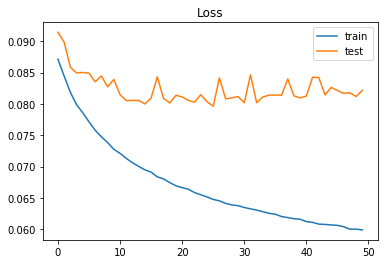

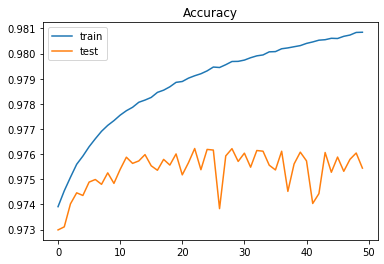

In [176]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [177]:
accr = RNNModel.evaluate(padXTest, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4796/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 5s 1ms/sample - loss: 0.0804 - accuracy: 0.9747
Test set
  Loss: 0.088
  Accuracy: 0.975


In [178]:
RNNModel.save('RNNforNER.h5')